# Quantum Computing Experimentation with Amazon Braket
### Chapter 12 - Multi-Objective Optimization Use Case

© 2021, 2022, 2023 Packt Publishing

Written by Alex Khan

In [1]:
# Enter the S3 bucket you created during onboarding in the code below
my_bucket = "amazon-braket-[your bucket]" # the name of the bucket
my_prefix = "[your folder]" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [2]:
from braket.circuits import Circuit, Gate, Observable
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd


In [4]:
from scipy.optimize import minimize, curve_fit


In [5]:
# to check all gate operations refer to 
# https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

https://docs.aws.amazon.com/braket/latest/developerguide/braket-constructing-circuit.html

In [6]:
def available_devices():
    from braket.aws import AwsDevice
    device_list=AwsDevice.get_devices(statuses=['ONLINE'])
    device_name_list=[]
    for device in device_list:
        device_name_list.append(device.name)
    #print('Valid device names: ',device_name_list)
    return(device_name_list)

In [7]:
available_devices()

['Aquila', 'Aspen-M-2', 'Borealis', 'IonQ Device', 'Lucy', 'SV1', 'TN1', 'dm1']

In [8]:
def set_device(Name):
    device_list=AwsDevice.get_devices(names=Name)
    if len(device_list)==1:
        device=device_list[0]
        print(device)
        return(device)
    else:
        print('No device found')
        print('use name from list', available_devices())

In [9]:
### Please run available_devices() and correct any device names below

def estimate_cost(device,num_shots=1000):
    #device=set_device(Name)
    cost_per_task=0.30
    Name=device.name
    if Name in ['SV1','TN1','dm1']:
        price_per_min=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('simulator cost per ',unit,': $', price_per_min)
        print('total cost cannot be estimated')
    elif Name in['Aspen-M-3','IonQ Device', 'Lucy','Aquila']:
        price_per_shot=device.properties.service.deviceCost.price
        unit=device.properties.service.deviceCost.unit
        print('device cost per ',unit,': $', price_per_shot)
        print('total cost for {} shots is ${:.2f}'.format(num_shots,cost_per_task+num_shots*price_per_shot))
    else:
        print('device not found')
        print('use name from list', available_devices())


In [10]:
# This function was modified with a return of num_shots
def estimate_cost_measured_qubits(device,measured_qubits):
    #device=set_device(Name)
    min_shots_per_variable=25
    max_shots=device.properties.service.shotsRange[1]
    print('max shots:', max_shots)
    num_shots=min_shots_per_variable*2**measured_qubits
    if num_shots>max_shots:
        num_shots=max_shots
        print('for {} measured qubits the maximum allowed shots: {:,}'.format(measured_qubits,num_shots))
    else:
        print('for {} measured qubits the number of shots recommended: {:,}'.format(measured_qubits,num_shots))
    estimate_cost(device,num_shots)
    return(num_shots)

In [11]:
def actual_simulator_cost(device, result):
        price_per_min=device.properties.service.deviceCost.price
        price_per_ms=price_per_min/60/1000
        unit=device.properties.service.deviceCost.unit
        duration_ms=result.additional_metadata.simulatorMetadata.executionDuration
        if unit=='minute':
            print('simulator cost per ',unit,': $', price_per_min)
            print('total execution time: ', duration_ms, "ms")
            print('total cost estimated: $',duration_ms*price_per_ms)

In [12]:
# this function has been updated from the function in past chapters
def run_circuit(circuit, shots, local=True, device_name='', s3_folder='', display_binary=False, disable_qubit_rewiring=False):
    import matplotlib.pyplot as plt
    %matplotlib inline
    if local==True:
        device = LocalSimulator()
        result = device.run(circuit, shots=shots).result()
    else:
        device=set_device(device_name)
        if shots==0:
            measured_qubits=len(circuit.qubits)
            num_reads=estimate_cost_measured_qubits(device,measured_qubits)
        else:
            num_reads=shots
        print('device', device)
        print('num reads', num_reads)
        if device_name=='Aspen-M-3':
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder, disable_qubit_rewiring=disable_qubit_rewiring).result()
        else:
            result = device.run(circuit, shots=num_reads, s3_destination_folder=s3_folder).result()
        if device_name in (['SV1','TN1']):
            actual_simulator_cost(device, result)
        else:
            estimate_cost(device, num_reads)
    counts = result.measurement_counts
    if display_binary==True:
        print(counts)
        plt.bar(int(counts.keys(),2), counts.values());
        plt.xlabel('states');
        plt.ylabel('counts');
    else:
        x_val=[]
        y_val=[]
        dec_counts={}
        for i in (counts.keys()):
            x_val.append(int(i,2))
        for i in (counts.values()):
            y_val.append(i)
        for i in range(len(x_val)):
            dec_counts[x_val[i]]=y_val[i]
        print(dec_counts)
        plt.bar(x_val, y_val)

        plt.xlabel('states');
        plt.ylabel('counts');
    
    return(result)

In [13]:
def draw_bloch(q, info=True):
    #©2021-2 Alex Khan
    
    import matplotlib.pyplot as plt
    import numpy as np

    if q.shape != (2,1):
        print('Matrix must be only for one qubit')
        print('Shape needed (2,1). Shape given ',q.shape)
        return
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_aspect("auto")
    if info==True:
        print('Matrix:')
        print(q)
    # draw Bloch Sphere
    u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
    x = np.cos(u)*np.sin(v)
    y = np.sin(u)*np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, color="y", alpha=0.2)

    u = np.linspace(0, 2* np.pi, 100)

    ax.plot(np.sin(u),np.cos(u),0*(u),color='y')
    ax.plot(0*(u),np.sin(u),np.cos(u),color='y')
    ax.plot(np.sin(u),0*(u),np.cos(u),color='y')

    # draw axes
    ax.plot([0,0],[1,-1],[0,0], color='y', linestyle='dotted')
    ax.plot([1,-1],[0,0],[0,0], color='y', linestyle='dotted')
    ax.plot([0,0],[0,0],[1,-1], color='y', linestyle='dotted')

    # draw state labels
    ax.annotate("|0>", xy=(0.0, 0.04), xytext=(0.0, 0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|1>", xy=(0.0, -0.04), xytext=(0.0, -0.07), arrowprops=dict(arrowstyle="->"), color='y')
    ax.annotate("|+>", xy=(-0.025, -0.022), xytext=(-0.06, -0.04), arrowprops=dict(arrowstyle="->"), color='y')

    # calculate vector
    
    r0=((q[0].real)**2+(q[0].imag)**2)**0.5
    #print('r0=',r0)
    if r0==0:
        phi0=0
    else:
    
        phi0=np.arccos(q[0].real/r0)
    
    r1=((q[1].real)**2+(q[1].imag)**2)**0.5
    #print('r1=',r1)
    if r1==0:
        phi1=0
    else:
    
        phi1=np.arccos(q[1].real/r1)
    r=(r0**2+r1**2)**0.5
    
    if(r<0.999 or r>1.0001):
        print('vector is  not normalized.  Cannot draw')
        return
    
    if np.sin(q[1].imag)<0:
        s1=-1
    else:
        s1=+1#

    if np.sin(q[0].imag)<0:
        s0=-1
    else:
        s0=+1
    

    #print('phi1',phi1,'phi0', phi0)
    phi=s1*phi1-s0*phi0   


    theta=2*np.arccos((q[0].real**2+q[0].imag**2)**0.5)
    
    v_x = np.cos(phi)*np.sin(theta)
    v_y = np.sin(phi)*np.sin(theta)


    v_z = np.cos(theta)
    v_z2= np.sin(theta)
    #print('theta',theta, 'phi',phi)

    #print('vx=cos(phi)',np.cos(phi), 'x sin(theta)', np.sin(theta),'= ',v_x)
    #print('vy=sin(phi)',np.sin(phi), 'x sin(theta)', np.sin(theta),'= ',v_y )
    #print('vz=cos(theta)', v_z)
    
    # print state
    if info==True:
        print(' ')
        print('State Vector: |psi> = sqrt(', q[0].real**2+q[0].imag**2, ') |0> + ( sqrt(', q[1].real**2+q[1].imag**2,')) e^i', phi/np.pi,'pi |1>')
        print(' ')
    # draw vector
    ax.quiver(0,0,0,v_y, -v_x, v_z, color='r')
    #print('cartesian coordinates on Bloch Sphere')
    #print(v_x, v_y, v_z)
    plt.axis('off')
    fig.set_size_inches(7, 7)
    #ax.view_init(10, 10, 10)
    #print('Bloch Sphere:')
    plt.show()
    return(q)

In [14]:
def draw_circuit(circ, info=True):
    # this function is only for one qubit and draws the Bloch sphere
    circ=circ.state_vector()
    if info==True:
        print(circ)
    device = LocalSimulator()
    result = device.run(circ).result()
    arr_r=np.array([[result.values[0][0]],[result.values[0][1]]])
    draw_bloch(arr_r, info)

In [15]:
def qft_gate(qc,qubits_needed):
    
    power=0

    for target in range(qubits_needed-1,-1,-1):
        qc.h(target)
        for control in range(target-1,-1,-1):
 
            power=target-control

            qc.cphaseshift(control, target, (np.pi/(2**(power))))


    #reverse qubits

    #for i in range (int(qubits_needed/2)):
        
        #qc.swap(i,qubits_needed-i-1)
    return(qc)

In [16]:
def qft_inv_gate(qc, qubits_needed, q_start=0):
    
    power=0

    for target in range(0,qubits_needed):
        
        for control in range(0,target):

            power=target-control

            qc.cphaseshift(control+q_start, target+q_start, -(np.pi/(2**(power))))
        
        qc.h(target+q_start)
    
    for i in range (int(qubits_needed/2)-1,-1,-1):
        
        qc.swap(i+q_start,qubits_needed-i-1+q_start)

    return(qc)

In [17]:
def draw_multi_qubit_phase(Qubits, Number, add_hadamard=True):

    b_Number=format(Number, '0'+str(Qubits)+'b')

    print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number)
    # qc builds the full circuit 
    # circ is only a qubit by qubit model for showing the bloch sphere
    qc=Circuit()
    for q in range(Qubits):
        print('qubit',q)
        circ=Circuit().h(0)
        
        if add_hadamard==True:
            qc=qc.h(q)
        p=0
        for i in range(Qubits-q-1,Qubits):

            if b_Number[i]=='1':
                circ.phaseshift(0,np.pi/(2**p))
                qc.phaseshift(q,np.pi/(2**p))

            p+=1
        # draw the bloch sphere for each qubit
        draw_circuit(circ, False) 
    return(qc)
        
        
    

In [18]:
def qc_num(num, qubits_needed):
    qubits_format='0'+str(qubits_needed)+'b'
    n_bin=format(num, qubits_format)

    qubits_needed=len(n_bin)

    qc=Circuit()
    for i in range(qubits_needed):
        if n_bin[i]=='1':
            #reverse number
            #qc.x(qubits_needed-i-1)
            qc.x(qubits_needed-i-1)


    return(qc)

In [19]:
def add_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,np.pi/(2**p))

            p+=1

    return(qc)

In [20]:
def subtract_coefficient(qc, q_start, Qubits, control_qubit, Number):
    b_Number=format(Number, '0'+str(Qubits)+'b')

    #print('Qubits:', Qubits, 'Number:', Number, 'binary:', b_Number, q_start, control_qubit)


    for q in range(Qubits):
        #print('qubit',q)

        p=0
        for k in range(Qubits-q-1,Qubits):

            if b_Number[k]=='1':

                qc.cphaseshift(control_qubit,q+q_start,-np.pi/(2**p))

            p+=1

    return(qc)

In [21]:
def matrix_to_polynomial(objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    #extra_qubits={}
    #r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    #extra_qubits[(i,j)]=r2
                    #r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    return(eq)

In [22]:
def multi_qubit_polynomial(Qubits, objective):
    #Qubits=3    
    #objective=np.array([[2,-1],[0,3]])
    eq=''
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
    len_r1=len(objective)

    extra_qubits={}
    r2=len_r1
    ex_qu=0

    for i in range (len_r1):
        if objective[i,i]<0:
            eq=eq+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)
        elif objective[i,i]>0:
            eq=eq+'+'+str(objective[i,i])+'x'+str(i).translate(SUB)+'2'.translate(SUP)

    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:

                if objective[i,j]<0:
                    extra_qubits[(i,j)]=r2
                    r2+=1
                    eq=eq+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
                elif objective[i,j]>0:
                    extra_qubits[(i,j)]=r2
                    r2+=1                
                    eq=eq+'+'+str(objective[i,j])+'x'+str(i).translate(SUB)+'x'+str(j).translate(SUB)
    print(eq)
    # starting qubit for register 2

    q_start=r2

    qc=Circuit()

    #qc=qc.x(1).x(0)
    qc=qc.h(np.arange(len_r1))


    for q in range(Qubits):
        qc=qc.h(q+q_start)


    for i in range (len_r1):
        if objective[i,i]<0:
            qc=subtract_coefficient(qc, q_start, Qubits, i, objective[i,i])
        elif objective[i,i]>0:
            qc=add_coefficient(qc, q_start, Qubits, i, objective[i,i])
    for i in range (len_r1):
        for j in range (len_r1):
            if i<j:
                if objective[i,j]<0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=subtract_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])
                elif objective[i,j]>0:
                    qc=qc.ccnot(i,j,extra_qubits[i,j])
                    qc=add_coefficient(qc, q_start, Qubits, extra_qubits[i,j], objective[i,j])

    qc=qft_inv_gate(qc, Qubits, q_start ) 

    
    return(qc, len_r1, q_start)

In [23]:
def plot_results_mc(counts):

#    figure(figsize=(10, 6), dpi=100)

    len1=len(objective)
    print('valid values',-max_val/2,'to',max_val/2)
    x_val=[]
    y_val=[]
    cost=[]
    #print(len1,Qubits)
    for val in zip(counts.values(), counts.keys()):
        result=int(val[1][q_start:q_start+Qubits],2)
        #print(val[1], val[1][0:len1], result, val[0])
        if result <= max_val/2:


            x_val.append(str(val[1][0:len1])+'('+str(result)+')')
            y_val.append(val[0])
            cost.append(result)
        else:
            x_val.append(str(val[1][0:len1])+'('+str(result-max_val)+')')
            y_val.append(val[0])
            cost.append(result-max_val)        

    sort_index = np.argsort(cost)
    x_val = [x_val[i] for i in sort_index]
    y_val = [y_val[i] for i in sort_index]
    cost = [cost[i] for i in sort_index]

    print('from lowest to highest value')
    print('input (cost) count')
    print('-----  ----- -----')
    for i in range(len(x_val)):
        print(x_val[i], y_val[i])
    
    plt.bar(x_val, y_val)
    plt.xlabel('value')
    plt.ylabel('counts')
    plt.xticks(rotation = 89) # Rotates X-Axis Ticks by 45-degrees
    plt.show()

In [24]:
def sum_energy(Q,array):
    vals=[]
    for i in range(len(array)):
        if array[int(i)]=='1':
            vals.append(i)
            
    sum=0
    #print(vals)
    for i in (vals):
        sum+=Q[int(i),int(i)]
    for i in (vals):
        for j in (vals):
            if i<j:
                sum+=Q[int(i),int(j)]
    return(sum)
            
    

In [25]:

def param_optimizer(param1, param2, Q, shots):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))


    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            qc=qc.x(range(len(Q))).h(range(len(Q)))
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            device = LocalSimulator()
            result = device.run(qc, shots=shots).result()
            counts = result.measurement_counts

            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
#    plt.figure(1, figsize=[7, 5])
    #sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    sns.heatmap(D, 
            annot=True, 
            xticklabels=[f'{x:.0}' for x in param2], 
            yticklabels=[f'{x:.0}' for x in param1],  
            linewidths=.5, 
            cmap="YlGnBu", 
            annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [26]:
def param_optimizer_device(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))

    
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-M-3':
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, True)
            counts = result.measurement_counts
            
            solution=[]
            quantity=[]
            energy=[]
            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
            index=np.argsort(energy)

            #plt.scatter(energy,quantity)   
            #plt.show()
            D[p1,p2]=energy[index[0]]
            if energy[index[0]]<lowest_energy:
                lowest_energy=energy[index[0]]
                lowest_param1=param1[p1]
                lowest_param2=param2[p2]
            

            #print(p1,p2,'lowest',energy[0])
#    plt.figure(1, figsize=[7, 5])
    #sns.heatmap(D, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
    sns.heatmap(D, 
            annot=True, 
            xticklabels=[f'{x:.0}' for x in param2], 
            yticklabels=[f'{x:.0}' for x in param1],  
            linewidths=.5, 
            cmap="YlGnBu", 
            annot_kws = {'alpha': 1})
    plt.title('parameter landscape');
    plt.tight_layout();
    return(lowest_param1, lowest_param2, lowest_energy)

In [27]:
def schedule_task(qc, shots, device):
    if device.name=='Aspen-M-3':
        qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60, disable_qubit_rewiring=disable_qubit_rewiring)
    else:
        qc_task = device.run(qc, s3_folder, shots=shots, poll_timeout_seconds=5*24*60*60)
    qc_status = qc_task.state()
    print('ID of task:', qc_task.id)
    print('Status of task:', qc_status)
    
    # to retrieve task use
    # results, metadata, counts=recover_task_sum(qc_task_id)
    return(qc_task.id)

In [28]:
def recover_task(task_id):
    # recover task
    task_load = AwsQuantumTask(arn=task_id)

    # print status
    status = task_load.state()
    #print('Status of (reconstructed) task:', status)

    # wait for job to complete
    # terminal_states = ['COMPLETED', 'FAILED', 'CANCELLED']
    if status == 'COMPLETED':
        # get results
        results = task_load.result()
        # print(rigetti_results)

        # get all metadata of submitted task
        metadata = task_load.metadata()
        # example for metadata
        shots = metadata['shots']
        machine = metadata['deviceArn']
        # print example metadata
        print("{} shots taken on machine {}.".format(shots, machine))

        # get measurement counts
        counts = results.measurement_counts
        #print('Measurement counts:', counts)

        return(results, metadata, counts)
       
       

    elif status in ['FAILED', 'CANCELLED']:
        # print terminal message 
        print('Your task is in terminal status, but has not completed.')

    else:
        # print current status
        print('Sorry, your task is still being processed and has not been finalized yet.')

In [29]:
def schedule_optimize_bqm_task(param1, param2, Q, shots, device):
    
    qc=Circuit()
    for i in range(len(Q)):
        if Q[i,i]!=0:
            #print(i,Q[i,i])
            qc=qc.x(i).h(i)
    #qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        if device.name=='Aspen-M-3':
                            qc=qc.cnot(i, j).rz(j, param1[p]*Q[i,j]).cnot(i, j)
                        else:
                            qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rx(i,2*param2[p])
    
    qc_task_id=schedule_task(qc, shots, device)
    
    return(qc_task_id)


In [30]:
# |0> state
arr_0=np.array([[1+0j],[0+0j]])
# |1> state
#arr_1=np.array([[0],[1]])
arr_1=np.array([[0+0j],[1+0j]])


# i operator
arr_i=np.array([[1,0],[0,1]])
# x operator
arr_x=np.array([[0,1],[1,0]])
# y operator
arr_y=np.array([[0,-1j],[1j,0]])
# z opeator
arr_z=np.array([[1,0],[0,-1]])
# h operator
arr_h=(1/np.sqrt(2))*(np.array([[1, 1],[1, -1]]))
# t operator
arr_t=np.array([[1,0],[0,np.exp(1j*np.pi/4)]])
# s operator
arr_s=np.array([[1,0],[0,np.exp(1j*np.pi/2)]])

In [31]:
def func_bqm(x):
    # This function is used by the scipy optimizer
    # It takes a matrix Q and returns the lowest energy found for a single set of parameters in x
    # It allows scipy to find the optimal single set of parameters
    #
    global Q
    global shots
    global param1_list
    global param2_list
    global min_value_list
    global quantity_list
    global solution_list
    global SV
    param1=x[0]
    param2=x[1]
    sum=0
    qc=Circuit()
    
    Qubits=len(Q)
    qc=qc.x(range(Qubits)).h(range(Qubits))
    for i in range(Qubits):
        if Q[i,i]!=0:
            qc=qc.rz(i,-2*param1*Q[i,i])
    for i in range (Qubits):
        for j in range (Qubits):
            if i<j:
                if Q[i,j]!=0:
                    qc=qc.zz(i,j,2*param1*Q[i,j])
    for i in range(len(Q)):
        qc=qc.rx(i,2*param2)
    
    device = LocalSimulator()
    solution=[]
    quantity=[]
    energy=[]
    
    if SV==True:
        qc=qc.state_vector()
        result = device.run(qc, shots=0).result()
        #print(result.values)
        counter=0
        for res in (result.values[0]):
            quantity.append(abs(res)**2)
            keys=format(counter, '0'+str(Qubits)+'b')
            #print(keys)
            solution.append(keys)
            counter+=1
            energy.append(sum_energy(Q,keys))

    else:
        result = device.run(qc, shots=shots).result()
        counts = result.measurement_counts

        for keys,values in zip(counts.keys(),counts.values()):
            solution.append(keys)
            quantity.append(values)
            energy.append(sum_energy(Q,keys))
    
    index=np.argsort(energy)
    param1_list.append(param1)
    param2_list.append(param2)
    min_value_list.append(energy[index[0]])
    solution_list.append(solution[index[0]])
    quantity_list.append(quantity[index[0]])
    return(energy[index[0]])

In [32]:
def optimize_bqm(param1, param2, Q, shots):
    # This function optimizes 
    qc=Circuit()
    qc=qc.x(range(len(Q))).h(range(len(Q)))

    for p in range(len(param1)):
        for i in range(len(Q)):
            if Q[i,i]!=0:
                qc=qc.rz(i,-2*param1[p]*Q[i,i])
        for i in range (len(Q)):
            for j in range (len(Q)):
                if i<j:
                    if Q[i,j]!=0:
                        qc=qc.zz(i,j,2*param1[p]*Q[i,j])
        for i in range(len(Q)):
            qc=qc.rx(i,2*param2[p])


    device = LocalSimulator()
    result = device.run(qc, shots=shots).result()
    counts = result.measurement_counts
    solution=[]
    quantity=[]
    energy=[]
    for keys,values in zip(counts.keys(),counts.values()):
        solution.append(keys)
        quantity.append(values)
        energy.append(sum_energy(Q,keys))
    energy_np=np.array(energy)
    index=np.argsort(energy)
    
#    figure(figsize=(10, 6), dpi=100)
    plt.title('param1:'+str(param1)+' param2:'+str(param2))
    plt.xlabel('cost')
    #plt.xlim(-3, 8)
    plt.ylabel('occurrence')
    #plt.ylim(0,2700)
    plt.scatter(energy,quantity)

    plt.show()
    return(solution[index[0]],energy[index[0]],quantity[index[0]])


In [33]:
def ProbabilisticSampler(Q,plot_limit,offset=0, min_limit=0, max_limit=0):
    #(C) 2021, 2022 Alex Khan 

    
    from itertools import combinations
    import numpy as np
    import pandas as pd
    import random
    import math
    import matplotlib.pyplot as plt
    
    def nCr(n,r):
        f = math.factorial
        return int(f(n) / f(r) / f(n-r))
    
    def random_combination(iterable, r):
        "Random selection from itertools.combinations(iterable, r)"
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        return list(tuple(pool[i] for i in indices))
    
    def sum(i_list, Q):
        sum_lq=0

        for i in (i_list):
            for j in (i_list):
                
                sum_lq+=Q[i][j]
            
        return(sum_lq+offset)
    
    
    N=len(Q[0])
    if max_limit==0:
        max_limit=N
    t= (2**N)-1
    
    e_min=9999999
    count=0
    min_list=[]
    plot_data=[]
    x_label=[]
    comb_list=[]
    for n in range(min_limit,max_limit+1):  # for groups of items from 1 to N
        comb=nCr(N,n)
        comb_list.append(comb)
        #print('--m ', m, comb)
        if comb>plot_limit:
            combf=plot_limit
        else:
            combf=comb
                
        for i in range (combf):
            i_list=random_combination(range(N), n)
            plot_data.append(sum(list(i_list),Q))
            x_label.append(n)
            
            if sum(list(i_list),Q)<e_min:  

                    e_min=sum(list(i_list),Q)  
                    min_count=n
                    min_list=list(i_list)
                    
                    #print(list(i_list), sum(list(i_list),Q))
            count+=1
    #plt.plot(x_label,plot_data)
#   figure(figsize=(10, 6), dpi=100)
    plt.scatter(x_label,plot_data,s=1)
    plt.ylabel('Energy')
    plt.show()
    
    print('Best found:', min_list)
    print('count:', min_count)
    print('Energy:', e_min)
    print('Solutions Sampled:', count)
    #print('Total Possible solutions:', comb_list)
    return min_list, e_min, comb_list

In [34]:
#############################

In [94]:
def run_dwave(Q,strength):
    from dwave.system.samplers import DWaveSampler
    from dwave.system.composites import EmbeddingComposite
    import dimod 

    
    # sampler properties
    sampler = EmbeddingComposite(DWaveSampler())
    #Estimate cost and shots
    dim=len(Q)
    shots=25*2**dim
    print(shots)
    if shots>3000:
        shots=3000
    
    # create BQM
    linear={i:Q[i][i] for i in range(dim)}
    quadratic={(i,j):Q[i][j] for i in range(dim) for j in range(dim) if i<j}
    
    vartype = dimod.BINARY
    bqm = dimod.BinaryQuadraticModel(linear, quadratic, vartype)
    
    # Note: reduce shots if you want to reduce costs

    print('chain strength:',strength, 'shots:', shots)
     
    # run sampler
    response = sampler.sample(bqm, num_reads=shots, chain_strength=strength)
                              
    print(response)
                              
    solution=""
    for i in response:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    print('decimal equivalent:',int(solution,2))
                              
    print('Validate energy',sum_energy(Q,solution))
    return(response)

In [36]:
def run_neal(Q):
    import neal
    import dimod 
    Nsampler = neal.SimulatedAnnealingSampler()
    QDWaveSA = dimod.BinaryQuadraticModel(Q, dimod.BINARY)
    SAresponse = Nsampler.sample(QDWaveSA)
    for SAsample in SAresponse.data():
        print( SAsample)
    solution=""
    for i in SAresponse:
        print(i)
        for s in i:
            solution=solution+str(i[s])
        break
    print(solution)
    #print(int(solution,2))
    return(solution)

In [37]:
def generate_matrix(Qubits):
    #Generate a fixed matrix for desired number of Qubits
    import pandas as pd
    E = pd.read_csv("100x100.csv", header=None ).values
    if (len(E[0])==len(E[1])):
        dim=len(E)
        print(dim)
    Q=np.zeros((Qubits,Qubits))
    count=0
    for i in range(Qubits):
        for j in range(Qubits):
            if i<j:
                Q[i,j]=E[i,j]
            elif i==j:
                Q[i,j]=-E[i,j]
    return(Q)

In [38]:
def reverse(bitstring):
    return(bitstring[::-1])

In [39]:
def import_file(dat_file_name):
    import pandas as pd
    df = pd.read_csv(data_file_name, header=None)
    df.columns = ['value', 'weight']
    print(df)

    v=df['value']
    w=df['weight']
    return(v,w)

In [40]:
def plot_knapsack(file_name,w_capacity):
    from itertools import combinations
    import numpy as np
    import matplotlib.pyplot as plt
    
    def sum(i_list, p):
        sum_p=0
        for item in (i_list):
            sum_p+=p[item]
        return(int(sum_p))
    
    v,w=import_file(file_name)
    N=len(v)
    v_max=0
    w_max=0
    max_list=[]
    
    plot_w=[]
    plot_v=[]
    plot_wc=[]
    plot_vc=[]
    
    for n in range(1,N):  # for groups of items from 1 to N
        for i_list in combinations(np.arange(N), n): # allcombinations of n items

            plot_v.append(sum(list(i_list),v))  
            plot_w.append(sum(list(i_list),w))  
            #print(list(i_list),sum(list(i_list),v), sum(list(i_list),w))
            
            if sum(list(i_list),w)<=w_capacity: # if the weight of the current list of items is within the weight capacity

                plot_vc.append(sum(list(i_list),v))  
                plot_wc.append(sum(list(i_list),w))                
                
                if sum(list(i_list),v)>v_max:  # if the value of the current list of items is more than the max cost found so far
                    v_max=sum(list(i_list),v)  #c_max updated the cost of the current list of items
                    w_max=sum(list(i_list),w)  #w_max upated to the weifht of the current items
                    max_list=list(i_list)
                    print(list(i_list), sum(list(i_list),v),sum(list(i_list),w))

#    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_v)
    plt.ylabel('value without constraint')
    plt.show()
#    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_w)
    plt.ylabel('weight without constraint')
    plt.show()
#    figure(figsize=(10, 6), dpi=100)                
    plt.plot(plot_vc)
    plt.ylabel('value with constraint')
    plt.show()
#    figure(figsize=(10, 6), dpi=100)
    plt.plot(plot_wc)
    plt.ylabel('weight with constraint')
    plt.show()
    
    print('max value:',v_max, 'weight used:',w_max)
    print('items included:',max_list)
    return

In [41]:
def quantum_device_sampler(param1, param2, Q, shots,device_name):
    import seaborn as sns
    lowest_energy=999999
    lowest_param1=0
    lowest_param2=0
    D=np.zeros((len(param1),len(param2)))
    solution=[]
    quantity=[]
    energy=[]
    
    for p1 in range(len(param1)):
        for p2 in range(len(param2)):

            qc=Circuit()
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    #print(i,Q[i,i])
                    qc=qc.x(i).h(i)
            
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rz(i,-2*param1[p1]*Q[i,i])
            for i in range (len(Q)):
                for j in range (len(Q)):
                    if i<j:
                        if Q[i,j]!=0:
                            if device_name=='Aspen-M-3':
                                qc=qc.cnot(i, j).rz(j, param1[p1]*Q[i,j]).cnot(i, j)
                            else:
                                qc=qc.zz(i,j,2*param1[p1]*Q[i,j])
            for i in range(len(Q)):
                if Q[i,i]!=0:
                    qc=qc.rx(i,2*param2[p2])
            #print(qc)
            

            result=run_circuit(qc, shots, False, device_name, s3_folder, False, False)
            counts = result.measurement_counts
            

            for keys,values in zip(counts.keys(),counts.values()):
                solution.append(keys)
                quantity.append(values)
                energy.append(sum_energy(Q,keys))
                #print(keys, values, sum_energy(Q,keys))
    
    index=np.argsort(energy)

    return(solution, quantity, energy, index)

In [42]:
def knapsack_QUBO(value, weight, weight_capacity):

    N=len(value)
    Mv = np.zeros([N,N],dtype=float)
    for i in range(N):
        Mv[i][i] =-value[i]
    N=len(value)
    Mx = np.zeros([N,N],dtype=float)
    for i in range(N):
        for j in range(N):
            if i==j:
                Mx[i][i] =weight[i]**2
            elif i<j:
                Mx[i][j]=2*weight[i]*weight[j]
    wc=weight_capacity
    Myc = np.zeros([wc,wc],dtype=float)
    for i in range(wc):
        for j in range(wc):
            if i==j:
                Myc[i][i] =-1
            elif i<j:
                Myc[i][j]=2
    wc=weight_capacity
    My = np.zeros([wc,wc],dtype=float)
    for n in range(1,wc+1):
        for m in range(1,wc+1):
            if n==m:
                My[n-1][m-1] =n**2
            elif n<m:
                My[n-1][m-1] =2*(n*m)
    wc=weight_capacity
    Mxy = np.zeros([N,wc],dtype=float)
    for i in range(N):
        for n in range(1,wc+1):

                Mxy[i][n-1] =-2*weight[i]*n
    A=300 #ensure only one weight is selected
    B=1 # ensure weight matches total weight
    C=1   # ensure correct items are selected

    Mxf=C*np.array(Mv)+B*np.array(Mx)
    Myf=A*np.array(Myc)+B*np.array(My)
    MxyMyf=np.append(B*Mxy, Myf , axis=0) 
    Mxzeros=np.zeros([wc,N],dtype=float)
    Mxflarge=np.append(Mxf, Mxzeros, axis=0)
    Mf=np.append(Mxflarge,MxyMyf, axis=1)
    return(Mf)

#np.savetxt('Mf.csv', Mf, delimiter=',')
#print(Mv)

In [43]:
def SetCoverSampler(Q,c_list,plot_limit,offset=0, min_limit=0, max_limit=0):
    #(C) 2021, 2022 Alex Khan 

    
    from itertools import combinations
    import numpy as np
    import pandas as pd
    import random
    import math
    import matplotlib.pyplot as plt
    
    def nCr(n,r):
        f = math.factorial
        return int(f(n) / f(r) / f(n-r))
    
    def random_combination(iterable, r):
        "Random selection from itertools.combinations(iterable, r)"
        pool = tuple(iterable)
        n = len(pool)
        indices = sorted(random.sample(range(n), r))
        return list(tuple(pool[i] for i in indices))
    
    def sum(i_list, Q):
        #i_list is combinations of supplier to try
        #c_list is the universe of items needed
        #covered is the list of suppliers that cover the items
        covered=np.zeros(len(c_list))
        sum_lq=len(c_list)
        
        for i in (i_list):
            for j in range(len(c_list)):
                
                if Q[i,c_list[j]]==1:
                    covered[j]=1
        sum_lq=-np.sum(covered)
            
        return(sum_lq+offset)
    
    
    N=np.shape(Q)[0]
    print('max random',N)
    if max_limit==0:
        max_limit=N
    t= (2**N)-1
    
    e_min=9999999
    count=0
    min_list=[]
    plot_data=[]
    x_label=[]
    comb_list=[]
    for n in range(min_limit,max_limit+1):  # for groups of items from 1 to N
        comb=nCr(N,n)
        comb_list.append(comb)
        #print('--m ', m, comb)
        if comb>plot_limit:
            combf=plot_limit
        else:
            combf=comb
                
        for i in range (combf):
            i_list=random_combination(range(N), n)
            plot_data.append(sum(list(i_list),Q))
            x_label.append(n)
            
            if sum(list(i_list),Q)<e_min:  

                    e_min=sum(list(i_list),Q)  
                    min_count=n
                    min_list=list(i_list)
                    
                    #print(list(i_list), sum(list(i_list),Q))
            count+=1
    #plt.plot(x_label,plot_data)
#   figure(figsize=(10, 6), dpi=100)
    plt.scatter(x_label,plot_data,s=1)
    plt.ylabel('Energy')
    plt.show()
    
    print('Best found:', min_list)
    print('count:', min_count)
    print('Energy:', e_min)
    print('Solutions Sampled:', count)
    #print('Total Possible solutions:', comb_list)
    return min_list, e_min, comb_list

In [44]:
def availability(sa,Ma):
    a=[]
    dim=np.shape(Ma)[1]
    for s in sa:
        for i in range(dim):
            if Ma[s,i]==1:
                a.append(i)
        
    au=np.unique(a)
    return(au)
            
            
    

In [45]:
def item_m(items, Mi):
    dim=len(items)
    m_i=np.zeros((dim,dim))
    for i in range(dim):
        for j in range(dim):
            m_i[i,j]=Mi[items[i],items[j]]
    return(m_i)  
        
        

## 1. Multi-objective problem

### Evaluate the best product mix based on Scenario A

In [46]:
from numpy import genfromtxt

Mi = genfromtxt('items.csv', delimiter=',')
Ms = genfromtxt('supplier.csv', delimiter=',')
Ma = genfromtxt('availability.csv', delimiter=',')

In [47]:
print(np.shape(Mi))
print(Mi)

(80, 80)
[[-0.6   0.7   0.03 ...  0.02  0.01  0.03]
 [ 0.   -0.91  0.02 ...  0.03  0.04  0.  ]
 [ 0.    0.   -0.92 ...  0.01  0.02  0.04]
 ...
 [ 0.    0.    0.   ... -0.39  0.7   0.02]
 [ 0.    0.    0.   ...  0.    0.2  -0.9 ]
 [ 0.    0.    0.   ...  0.    0.   -0.34]]


In [48]:
print(np.shape(Ms))
print(Ms)

(30, 30)
[[-1.30e+00  3.35e-02  4.91e-02  2.83e-02  1.03e-01  6.93e-02  7.03e-02
   3.57e-03  7.35e-02  1.19e-02  2.40e-02  1.14e-01  5.54e-02  8.98e-02
   1.08e-01  8.33e-02  1.99e-02  5.05e-03  3.46e-02  2.63e-02  1.90e-02
   7.09e-02  6.71e-02  1.02e-01  1.21e-01  7.46e-02  1.22e-01  8.05e-02
   2.03e-02  3.35e-02]
 [ 0.00e+00 -1.66e-01  9.43e-02  8.85e-02  1.25e-01  5.67e-03  1.18e-01
   1.21e-01  7.58e-02  3.73e-02  6.86e-02  6.44e-02  1.59e-02  1.11e-01
   3.61e-02  3.19e-02  5.73e-02  9.75e-02  1.12e-01  1.20e-01  6.71e-02
   6.18e-02  9.89e-02  6.14e-02  2.23e-02  6.22e-02  1.00e-01  1.39e-02
   9.70e-02  1.02e-01]
 [ 0.00e+00  0.00e+00 -1.46e-01  1.20e-01  9.90e-02  1.01e-01  3.57e-02
   1.20e-01  2.57e-02  5.80e-02  5.95e-02  9.20e-02  9.72e-02  9.10e-02
   2.61e-02  2.89e-02  1.13e-01  1.11e-01  2.84e-02  9.74e-04  5.61e-03
   9.51e-02  7.67e-02  5.34e-02  9.30e-02  1.12e-01  8.92e-02  6.55e-02
   4.17e-02  1.04e-01]
 [ 0.00e+00  0.00e+00  0.00e+00 -2.33e-01  5.50e-02  1.03e

In [49]:
print(np.shape(Ma))
print(Ma)

(30, 80)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


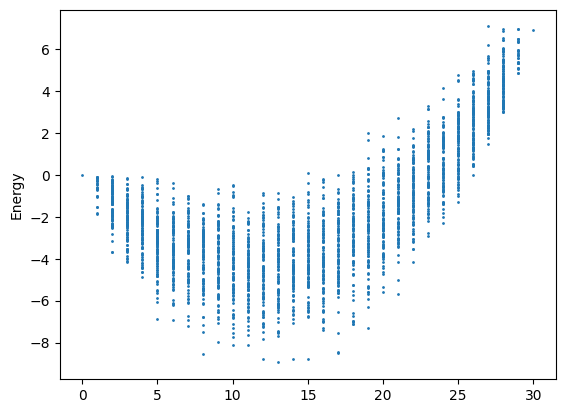

Best found: [0, 5, 7, 8, 10, 11, 13, 14, 16, 20, 25, 28, 29]
count: 13
Energy: -8.945819999999998
Solutions Sampled: 2762


In [50]:
sup_list=ProbabilisticSampler(Ms,100)

In [51]:
print(sup_list[0])
print('count', len(sup_list[0]))
print('energy', sup_list[1])

[0, 5, 7, 8, 10, 11, 13, 14, 16, 20, 25, 28, 29]
count 13
energy -8.945819999999998


In [52]:
# find products available at the suppliers
a=availability(sup_list[0],Ma)


In [53]:
print(len(a),a)

52 [ 0  2  3  5  9 13 16 17 18 19 22 24 25 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 44 45 46 47 48 49 50 51 52 53 55 58 60 63 65 66 67 69 70 74 75
 76 77 78 79]


In [54]:
m_i=item_m(a, Mi)

In [55]:
print(np.shape(m_i))
print(m_i)

(52, 52)
[[-0.6   0.03  0.   ...  0.02  0.01  0.03]
 [ 0.   -0.92  0.   ...  0.01  0.02  0.04]
 [ 0.    0.    0.2  ... -0.9  -0.9   0.03]
 ...
 [ 0.    0.    0.   ... -0.39  0.7   0.02]
 [ 0.    0.    0.   ...  0.    0.2  -0.9 ]
 [ 0.    0.    0.   ...  0.    0.   -0.34]]


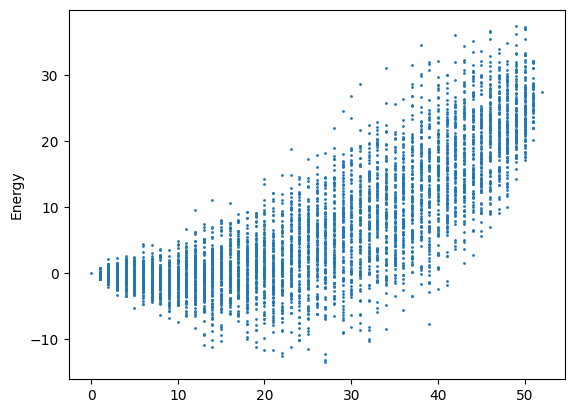

Best found: [0, 1, 2, 3, 4, 5, 9, 11, 14, 16, 17, 18, 22, 24, 26, 27, 28, 30, 31, 36, 38, 44, 45, 46, 48, 50, 51]
count: 27
Energy: -13.580000000000082
Solutions Sampled: 5006


In [56]:
p_items=ProbabilisticSampler(m_i,100)

In [57]:
print(p_items[0])
print('count', len(p_items[0]))
print('energy', p_items[1])

[0, 1, 2, 3, 4, 5, 9, 11, 14, 16, 17, 18, 22, 24, 26, 27, 28, 30, 31, 36, 38, 44, 45, 46, 48, 50, 51]
count 27
energy -13.580000000000082


## Determine the conflict based on the opposing objectives

### Evaluate results with the probabilistic solver

Collecting Plotting data for Scenario A

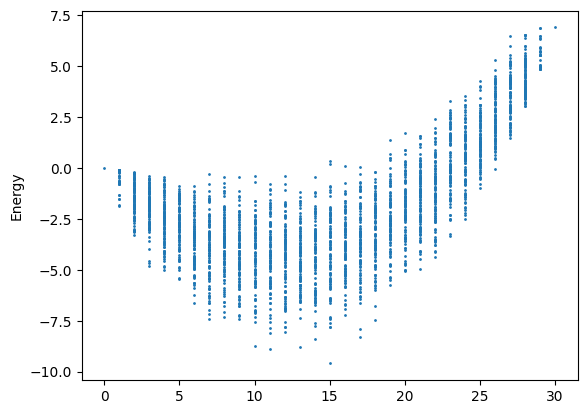

Best found: [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 20, 21, 27]
count: 15
Energy: -9.595049999999999
Solutions Sampled: 2762
Ideal suppliers: [0, 1, 4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 20, 21, 27]
Supplier energy -9.595049999999999
Items available: 52 [ 0  1  2  3  5  8  9 11 13 14 15 16 17 18 20 22 23 24 25 27 29 30 32 35
 36 38 39 40 41 42 44 45 46 47 48 50 51 52 53 55 57 58 59 62 66 69 70 74
 75 76 77 79]
(52, 52)


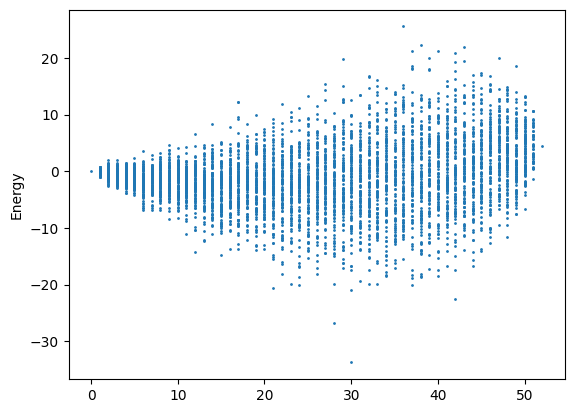

Best found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 16, 18, 19, 24, 25, 26, 27, 32, 34, 38, 39, 40, 42, 43, 44, 45, 46, 50, 51]
count: 30
Energy: -33.729999999999905
Solutions Sampled: 5006
Items in solution: [ 1.  2.  3.  5.  8.  9. 11. 13. 14. 15. 20. 23. 25. 27. 36. 38. 39. 40.
 46. 48. 53. 55. 57. 59. 62. 66. 69. 70. 77. 79.]
Item Energy -33.729999999999905


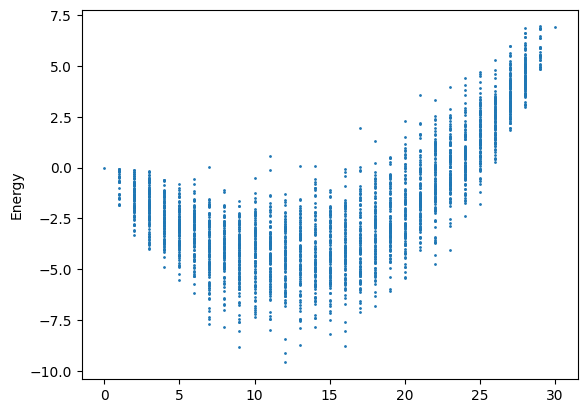

Best found: [0, 5, 6, 7, 10, 11, 12, 13, 14, 20, 24, 25]
count: 12
Energy: -9.589990000000002
Solutions Sampled: 2762
Ideal suppliers: [0, 5, 6, 7, 10, 11, 12, 13, 14, 20, 24, 25]
Supplier energy -9.589990000000002
Items available: 43 [ 0  1  2  3  5  9 16 17 22 25 29 32 35 36 38 39 40 41 42 44 45 46 47 48
 50 51 52 53 54 55 60 63 65 66 67 69 70 73 74 75 76 77 79]
(43, 43)


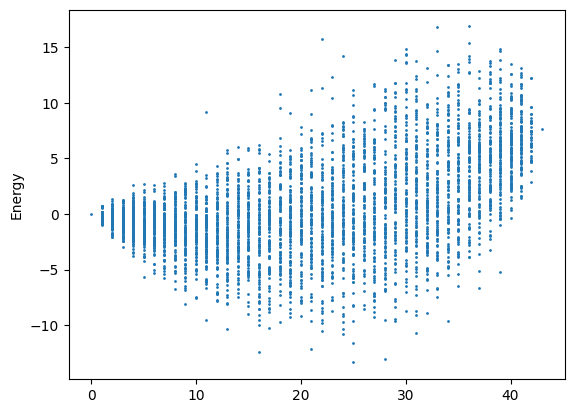

Best found: [1, 3, 4, 5, 7, 8, 9, 14, 15, 16, 20, 23, 24, 26, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40]
count: 25
Energy: -13.35000000000003
Solutions Sampled: 4088
Items in solution: [ 1.  3.  5.  9. 17. 22. 25. 38. 39. 40. 45. 48. 50. 52. 55. 60. 63. 65.
 66. 69. 70. 73. 74. 75. 76.]
Item Energy -13.35000000000003


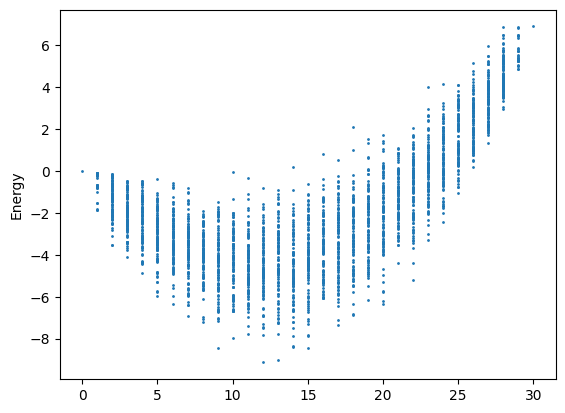

Best found: [6, 7, 8, 9, 10, 11, 12, 14, 15, 20, 27, 28]
count: 12
Energy: -9.14028
Solutions Sampled: 2762
Ideal suppliers: [6, 7, 8, 9, 10, 11, 12, 14, 15, 20, 27, 28]
Supplier energy -9.14028
Items available: 42 [ 0  1  2  3  5  9 11 16 17 22 24 25 29 30 31 32 33 34 35 37 38 39 40 42
 44 45 46 48 49 50 51 54 55 57 58 66 74 75 76 77 78 79]
(42, 42)


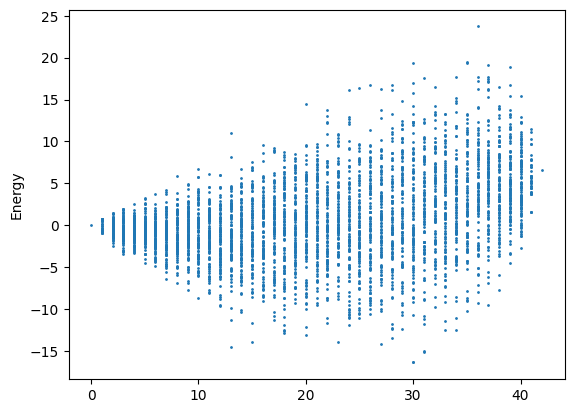

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 14, 17, 20, 21, 22, 23, 24, 25, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
count: 30
Energy: -16.370000000000037
Solutions Sampled: 3986
Items in solution: [ 0.  1.  2.  3.  5.  9. 11. 16. 17. 22. 25. 31. 34. 38. 39. 40. 42. 44.
 45. 50. 55. 57. 58. 66. 74. 75. 76. 77. 78. 79.]
Item Energy -16.370000000000037


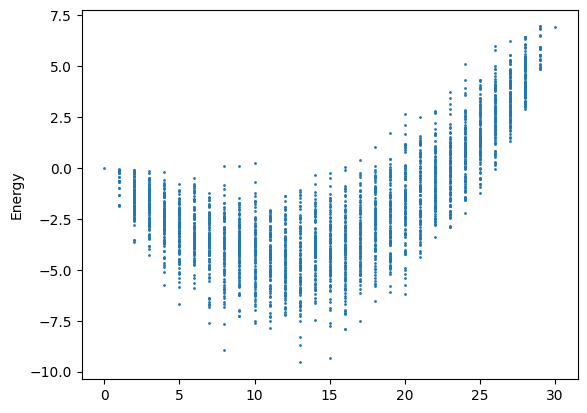

Best found: [0, 5, 6, 10, 11, 13, 14, 20, 21, 24, 26, 27, 28]
count: 13
Energy: -9.55452
Solutions Sampled: 2762
Ideal suppliers: [0, 5, 6, 10, 11, 13, 14, 20, 21, 24, 26, 27, 28]
Supplier energy -9.55452
Items available: 50 [ 0  1  2  3  5  8  9 11 13 15 17 18 20 22 23 24 25 27 28 29 31 32 35 36
 38 39 41 42 44 45 46 47 48 49 50 51 52 53 55 57 58 63 66 69 70 73 74 76
 77 79]
(50, 50)


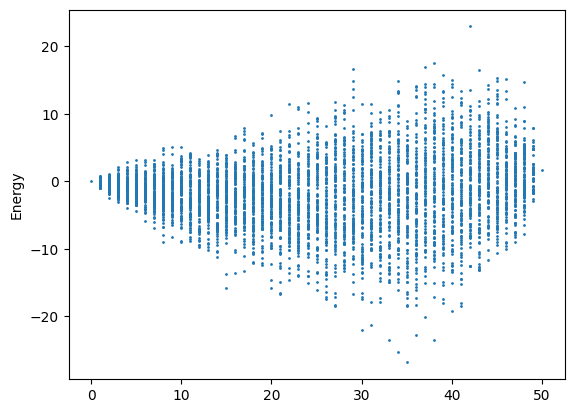

Best found: [1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 29, 31, 32, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 49]
count: 35
Energy: -26.82
Solutions Sampled: 4802
Items in solution: [ 1.  2.  3.  8.  9. 11. 13. 15. 17. 22. 23. 24. 25. 27. 32. 36. 38. 39.
 41. 42. 44. 45. 47. 48. 52. 53. 55. 57. 63. 66. 69. 70. 73. 74. 79.]
Item Energy -26.82


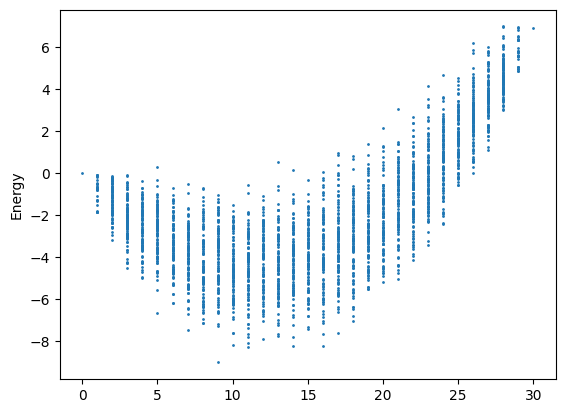

Best found: [5, 6, 7, 10, 11, 14, 17, 20, 25]
count: 9
Energy: -9.00705
Solutions Sampled: 2762
Ideal suppliers: [5, 6, 7, 10, 11, 14, 17, 20, 25]
Supplier energy -9.00705
Items available: 37 [ 0  1  2  3  4  5  7  9 10 16 17 22 25 35 38 39 40 42 44 45 46 48 50 51
 52 56 60 63 65 66 67 70 74 75 76 77 79]
(37, 37)


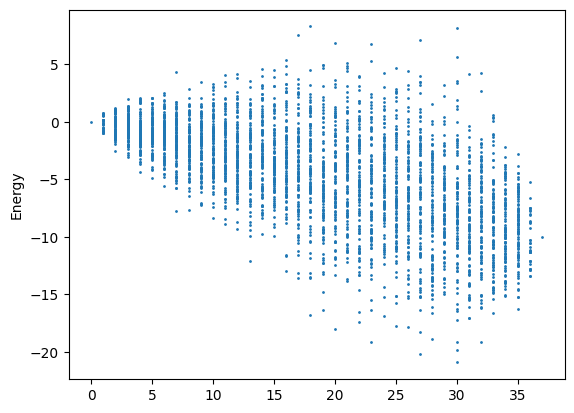

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36]
count: 30
Energy: -20.929999999999975
Solutions Sampled: 3476
Items in solution: [ 0.  2.  3.  4.  5.  7.  9. 10. 16. 22. 25. 38. 39. 40. 42. 44. 46. 48.
 51. 56. 60. 63. 65. 66. 70. 74. 75. 76. 77. 79.]
Item Energy -20.929999999999975


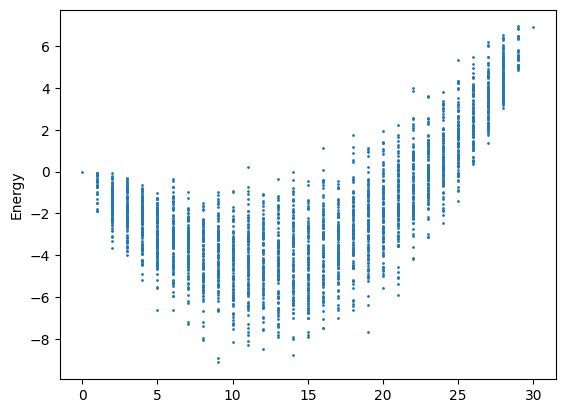

Best found: [4, 5, 6, 9, 10, 11, 13, 14, 20]
count: 9
Energy: -9.135600000000002
Solutions Sampled: 2762
Ideal suppliers: [4, 5, 6, 9, 10, 11, 13, 14, 20]
Supplier energy -9.135600000000002
Items available: 30 [ 0  1  2  3  5  9 22 25 30 32 35 38 39 40 42 44 46 48 50 51 55 57 58 59
 62 66 74 75 76 77]
(30, 30)


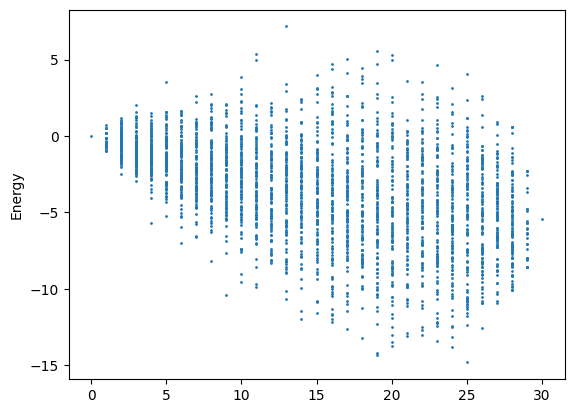

Best found: [1, 2, 3, 4, 5, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 26, 27, 28, 29]
count: 25
Energy: -14.820000000000054
Solutions Sampled: 2762
Items in solution: [ 1.  2.  3.  5.  9. 25. 30. 35. 38. 39. 40. 42. 44. 46. 48. 50. 51. 55.
 57. 58. 59. 74. 75. 76. 77.]
Item Energy -14.820000000000054


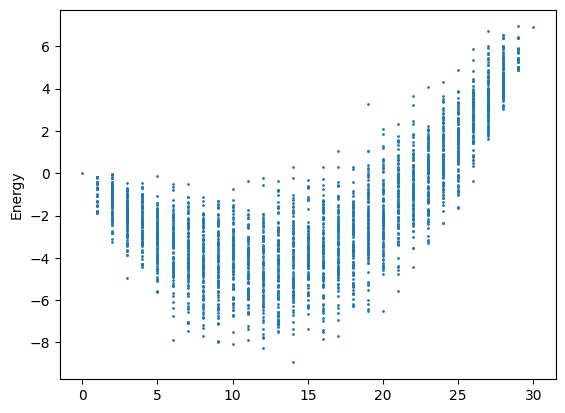

Best found: [0, 4, 5, 6, 7, 10, 13, 14, 18, 20, 21, 22, 26, 29]
count: 14
Energy: -8.947770000000002
Solutions Sampled: 2762
Ideal suppliers: [0, 4, 5, 6, 7, 10, 13, 14, 18, 20, 21, 22, 26, 29]
Supplier energy -8.947770000000002
Items available: 60 [ 0  1  2  3  5  6  8  9 10 12 13 15 16 17 18 20 21 22 23 24 25 27 28 29
 32 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 55 57 58 59 60
 62 63 64 65 66 69 70 71 74 76 77 79]
(60, 60)


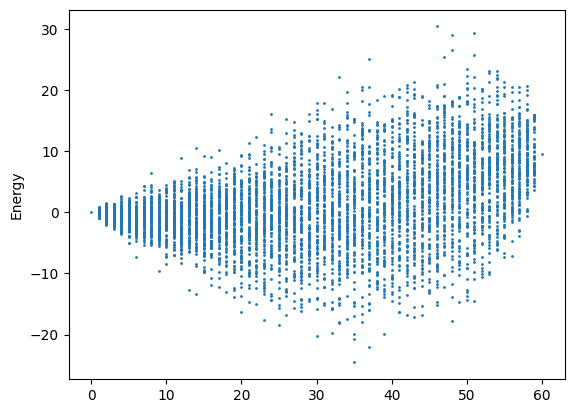

Best found: [0, 2, 4, 6, 7, 8, 9, 10, 11, 13, 15, 21, 22, 24, 26, 28, 29, 30, 31, 34, 36, 37, 39, 41, 42, 43, 44, 46, 49, 51, 52, 53, 54, 55, 57]
count: 35
Energy: -24.549999999999955
Solutions Sampled: 5822
Items in solution: [ 0.  2.  5.  8.  9. 10. 12. 13. 15. 17. 20. 27. 28. 32. 36. 38. 39. 40.
 41. 45. 47. 48. 50. 52. 53. 55. 57. 59. 63. 65. 66. 69. 70. 71. 76.]
Item Energy -24.549999999999955


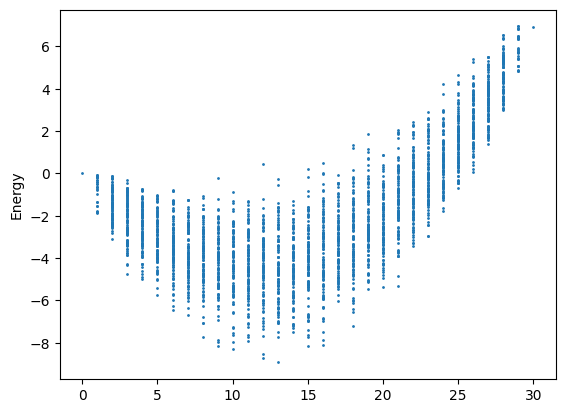

Best found: [0, 6, 8, 9, 10, 11, 14, 20, 21, 26, 27, 28, 29]
count: 13
Energy: -8.934899999999997
Solutions Sampled: 2762
Ideal suppliers: [0, 6, 8, 9, 10, 11, 14, 20, 21, 26, 27, 28, 29]
Supplier energy -8.934899999999997
Items available: 57 [ 0  1  2  3  5  8  9 11 13 15 18 20 22 23 24 25 27 28 29 30 31 32 33 34
 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 55 57 58 60 63 65
 66 69 70 74 75 76 77 78 79]
(57, 57)


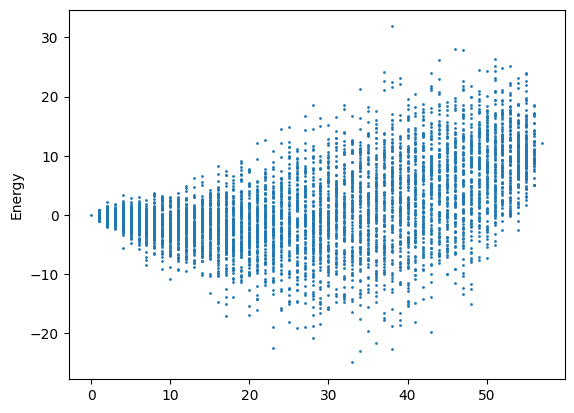

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 13, 15, 16, 18, 21, 22, 23, 26, 27, 28, 29, 31, 33, 34, 36, 37, 41, 42, 45, 46, 49, 50, 51, 52, 55]
count: 33
Energy: -24.970000000000013
Solutions Sampled: 5515
Items in solution: [ 0.  2.  3.  5.  8.  9. 11. 13. 23. 25. 27. 29. 32. 33. 34. 37. 38. 39.
 40. 42. 45. 46. 48. 49. 53. 55. 60. 63. 69. 70. 74. 75. 78.]
Item Energy -24.970000000000013


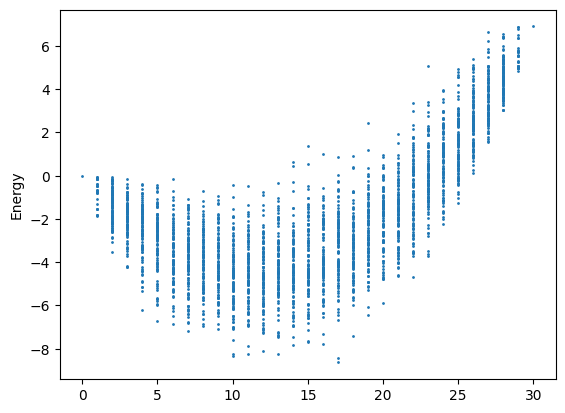

Best found: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 23, 24, 29]
count: 17
Energy: -8.63752
Solutions Sampled: 2762
Ideal suppliers: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 23, 24, 29]
Supplier energy -8.63752
Items available: 54 [ 0  1  2  3  5  6  8  9 13 15 16 17 18 20 22 23 24 25 27 29 30 32 33 34
 35 37 38 39 40 42 44 45 46 48 50 51 54 55 57 58 59 60 62 65 66 68 72 73
 74 75 76 77 78 79]
(54, 54)


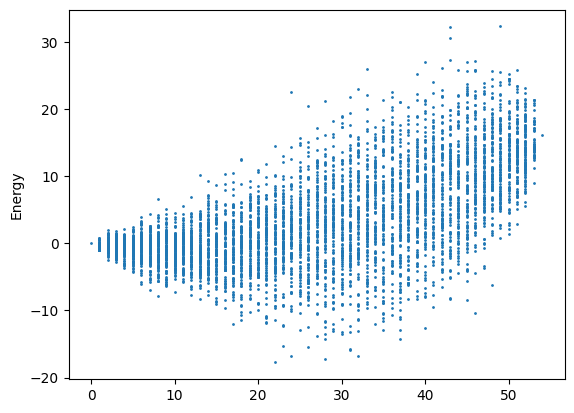

Best found: [3, 4, 5, 7, 9, 14, 17, 21, 23, 24, 27, 28, 32, 33, 37, 38, 39, 40, 42, 47, 49, 52]
count: 22
Energy: -17.750000000000057
Solutions Sampled: 5210
Items in solution: [ 3.  5.  6.  9. 15. 22. 25. 32. 34. 35. 39. 40. 46. 48. 55. 57. 58. 59.
 62. 73. 75. 78.]
Item Energy -17.750000000000057


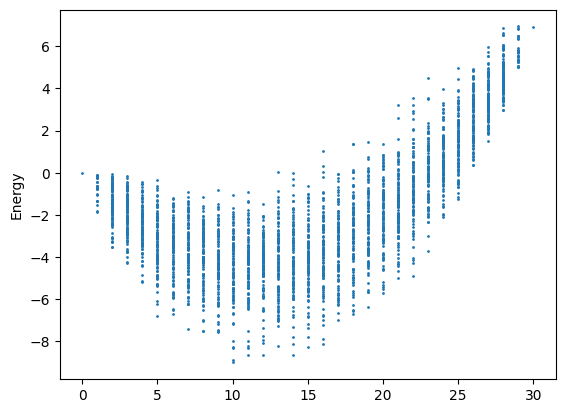

Best found: [5, 7, 9, 10, 11, 12, 14, 20, 24, 27]
count: 10
Energy: -9.008759999999999
Solutions Sampled: 2762
Ideal suppliers: [5, 7, 9, 10, 11, 12, 14, 20, 24, 27]
Supplier energy -9.008759999999999
Items available: 34 [ 0  2  3  5  9 11 16 17 22 25 30 32 35 38 39 40 42 44 45 46 48 50 51 54
 55 57 58 66 73 74 75 76 77 79]
(34, 34)


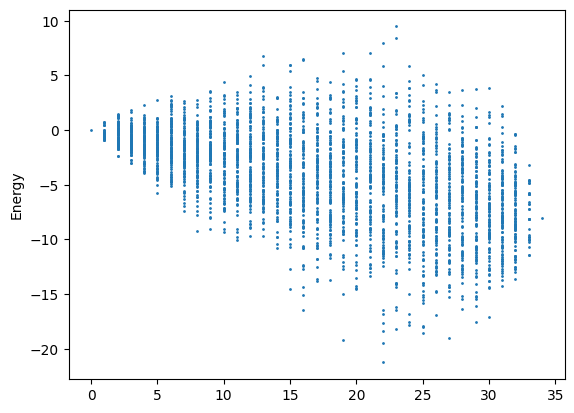

Best found: [1, 2, 3, 4, 5, 7, 8, 9, 14, 15, 17, 21, 22, 23, 24, 25, 26, 28, 29, 30, 32, 33]
count: 22
Energy: -21.26000000000004
Solutions Sampled: 3170
Items in solution: [ 2.  3.  5.  9. 11. 17. 22. 25. 39. 40. 44. 50. 51. 54. 55. 57. 58. 73.
 74. 75. 77. 79.]
Item Energy -21.26000000000004


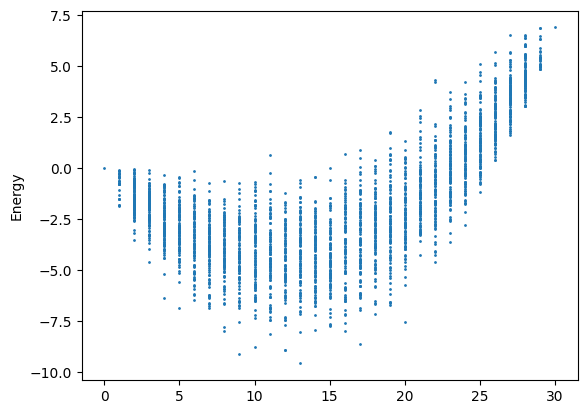

Best found: [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 20, 23]
count: 13
Energy: -9.593820000000001
Solutions Sampled: 2762
Ideal suppliers: [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 17, 20, 23]
Supplier energy -9.593820000000001
Items available: 51 [ 0  1  2  3  4  5  6  7  8  9 10 13 16 17 18 20 22 24 25 29 30 32 33 34
 35 37 38 39 40 42 44 45 46 48 50 51 55 56 57 58 59 62 66 68 72 74 75 76
 77 78 79]
(51, 51)


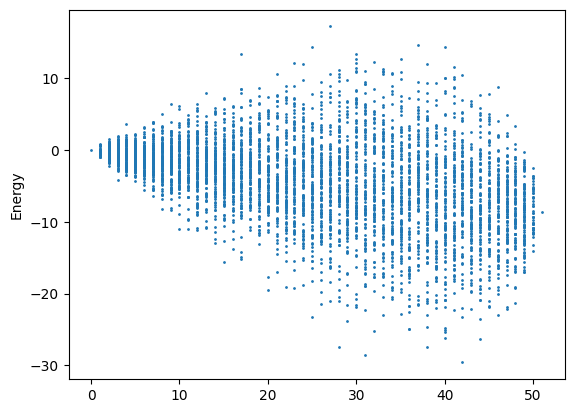

Best found: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 44, 45, 46, 50]
count: 42
Energy: -29.580000000000005
Solutions Sampled: 4904
Items in solution: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 13. 17. 18. 22. 24. 25. 32.
 33. 34. 35. 37. 38. 39. 40. 42. 44. 45. 46. 48. 50. 51. 55. 56. 57. 58.
 59. 62. 72. 74. 75. 79.]
Item Energy -29.580000000000005


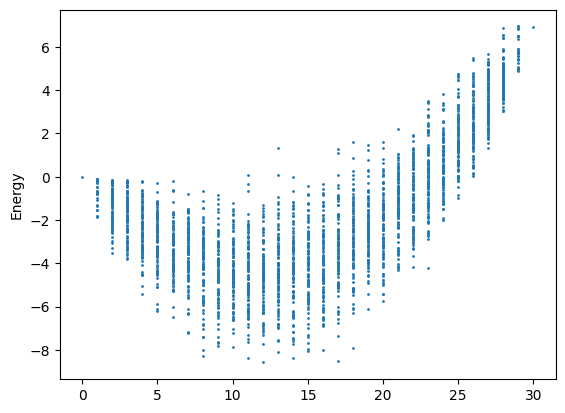

Best found: [0, 4, 6, 7, 11, 14, 15, 20, 21, 23, 27, 28]
count: 12
Energy: -8.583269999999997
Solutions Sampled: 2762
Ideal suppliers: [0, 4, 6, 7, 11, 14, 15, 20, 21, 23, 27, 28]
Supplier energy -8.583269999999997
Items available: 51 [ 0  1  2  3  5  6  8  9 11 13 15 16 17 18 20 22 23 24 25 27 29 31 32 35
 36 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 55 59 62 68 69 70 72 74
 76 77 79]
(51, 51)


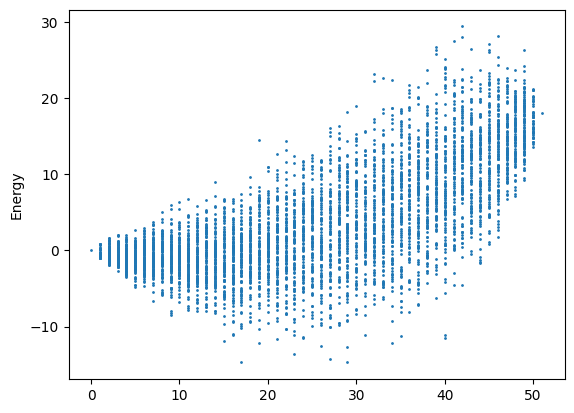

Best found: [6, 7, 9, 10, 15, 16, 18, 19, 22, 25, 27, 29, 37, 41, 44, 45, 47]
count: 17
Energy: -14.700000000000026
Solutions Sampled: 4904
Items in solution: [ 8.  9. 13. 15. 22. 23. 25. 27. 32. 38. 40. 42. 51. 59. 69. 70. 74.]
Item Energy -14.700000000000026


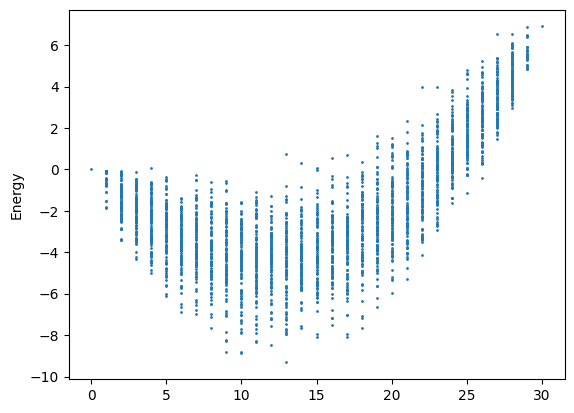

Best found: [0, 4, 5, 6, 7, 9, 10, 14, 17, 19, 20, 24, 29]
count: 13
Energy: -9.32272
Solutions Sampled: 2762
Ideal suppliers: [0, 4, 5, 6, 7, 9, 10, 14, 17, 19, 20, 24, 29]
Supplier energy -9.32272
Items available: 49 [ 0  1  2  3  4  5  7  9 10 16 17 22 25 29 30 32 35 36 38 39 40 41 42 44
 45 46 47 48 50 51 52 53 55 56 57 58 59 60 62 65 66 69 70 73 74 75 76 77
 79]
(49, 49)


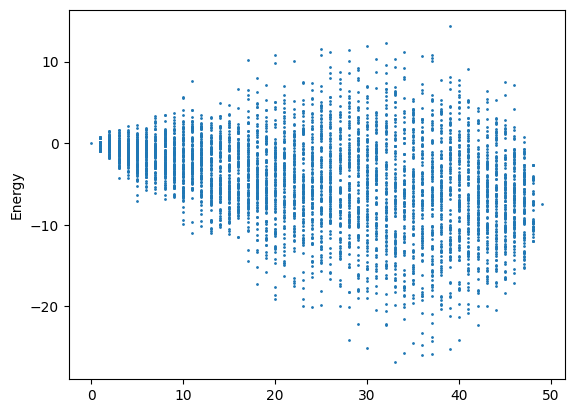

Best found: [0, 2, 3, 5, 6, 7, 8, 11, 14, 16, 17, 18, 19, 20, 21, 23, 25, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 46, 48]
count: 33
Energy: -26.900000000000087
Solutions Sampled: 4700
Items in solution: [ 0.  2.  3.  5.  7.  9. 10. 22. 30. 35. 36. 38. 39. 40. 41. 44. 46. 48.
 50. 52. 53. 55. 56. 57. 58. 62. 65. 66. 69. 70. 73. 76. 79.]
Item Energy -26.900000000000087


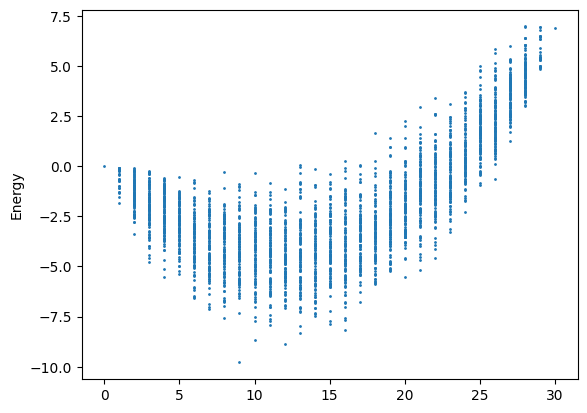

Best found: [5, 6, 7, 8, 10, 11, 14, 20, 22]
count: 9
Energy: -9.78778
Solutions Sampled: 2762
Ideal suppliers: [5, 6, 7, 8, 10, 11, 14, 20, 22]
Supplier energy -9.78778
Items available: 37 [ 0  1  2  3  5  9 16 17 22 24 25 29 30 32 33 34 35 37 38 39 40 41 42 44
 45 46 47 48 49 50 51 66 74 76 77 78 79]
(37, 37)


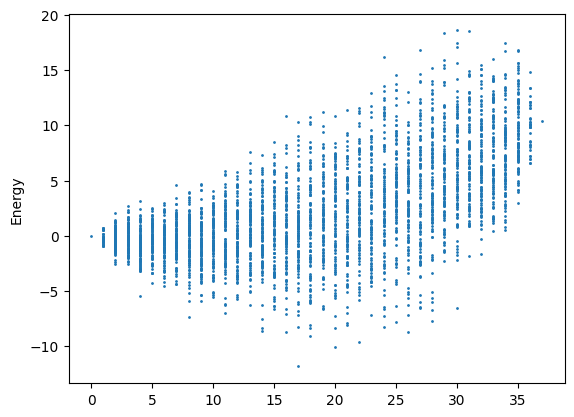

Best found: [1, 2, 3, 4, 5, 7, 13, 14, 15, 16, 19, 20, 22, 26, 33, 34, 35]
count: 17
Energy: -11.830000000000037
Solutions Sampled: 3476
Items in solution: [ 1.  2.  3.  5.  9. 17. 32. 33. 34. 35. 39. 40. 42. 47. 76. 77. 78.]
Item Energy -11.830000000000037


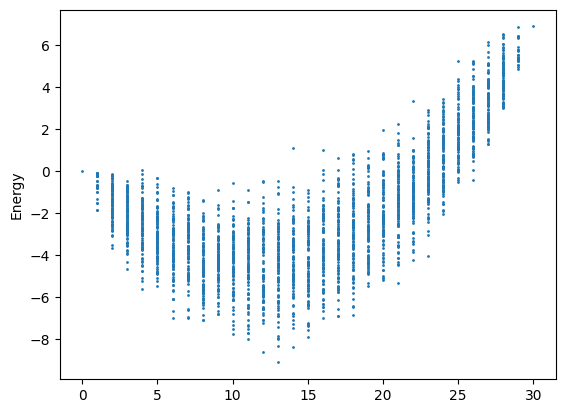

Best found: [0, 2, 5, 6, 7, 8, 9, 12, 13, 14, 18, 20, 28]
count: 13
Energy: -9.128570000000002
Solutions Sampled: 2762
Ideal suppliers: [0, 2, 5, 6, 7, 8, 9, 12, 13, 14, 18, 20, 28]
Supplier energy -9.128570000000002
Items available: 57 [ 0  1  2  3  5  6  9 10 12 14 16 17 18 20 21 22 24 25 26 29 30 31 32 33
 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50 51 52 53 54 55 57 58 64
 69 70 71 74 75 76 77 78 79]
(57, 57)


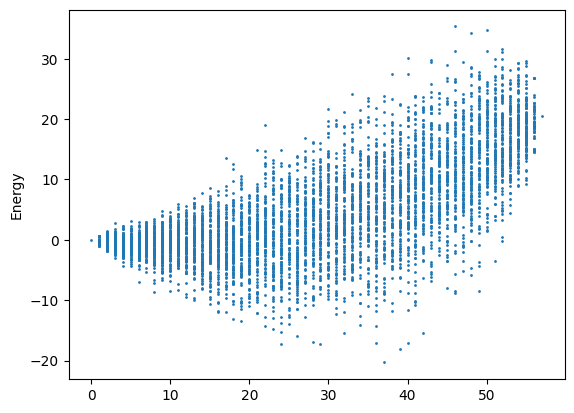

Best found: [1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 15, 17, 18, 19, 20, 24, 27, 28, 29, 30, 32, 33, 35, 37, 38, 39, 41, 44, 45, 48, 49, 51, 52, 53, 54, 55, 56]
count: 37
Energy: -20.310000000000038
Solutions Sampled: 5515
Items in solution: [ 1.  2.  3.  5.  9. 10. 12. 14. 16. 20. 22. 25. 26. 29. 30. 34. 37. 38.
 39. 40. 42. 44. 46. 48. 49. 50. 52. 55. 57. 69. 70. 74. 75. 76. 77. 78.
 79.]
Item Energy -20.310000000000038


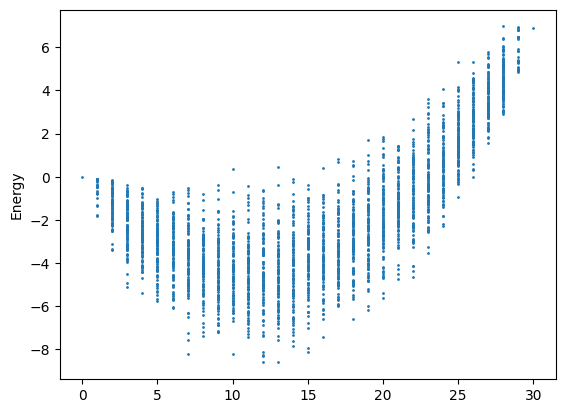

Best found: [0, 5, 6, 7, 9, 11, 14, 15, 17, 20, 22, 25, 26]
count: 13
Energy: -8.61863
Solutions Sampled: 2762
Ideal suppliers: [0, 5, 6, 7, 9, 11, 14, 15, 17, 20, 22, 25, 26]
Supplier energy -8.61863
Items available: 50 [ 0  1  2  4  5  7  9 10 16 17 22 24 25 28 29 30 32 35 36 37 38 39 40 41
 42 44 45 46 47 48 49 50 51 52 53 55 56 57 58 60 63 65 67 69 70 74 75 76
 77 79]
(50, 50)


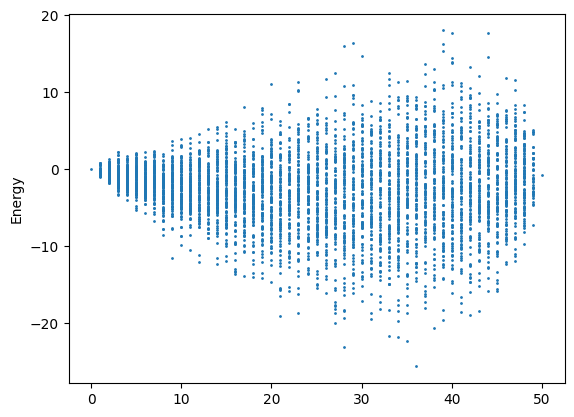

Best found: [0, 1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 27, 29, 31, 33, 34, 35, 36, 37, 38, 41, 43, 44, 45, 49]
count: 36
Energy: -25.600000000000115
Solutions Sampled: 4802
Items in solution: [ 0.  1.  2.  4.  9. 10. 16. 17. 22. 24. 25. 28. 30. 32. 35. 36. 37. 38.
 39. 40. 41. 42. 46. 48. 50. 52. 53. 55. 56. 57. 58. 65. 69. 70. 74. 79.]
Item Energy -25.600000000000115


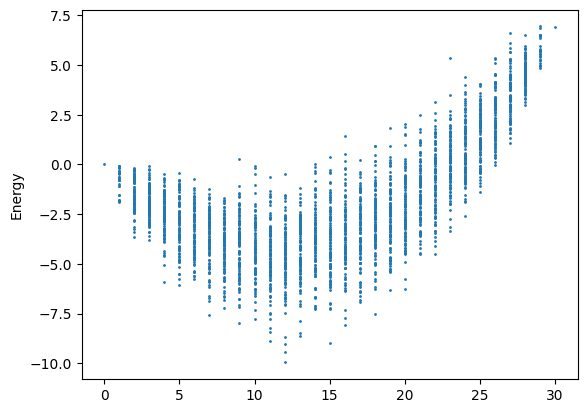

Best found: [0, 4, 5, 6, 10, 11, 14, 15, 20, 21, 28, 29]
count: 12
Energy: -9.956480000000003
Solutions Sampled: 2762
Ideal suppliers: [0, 4, 5, 6, 10, 11, 14, 15, 20, 21, 28, 29]
Supplier energy -9.956480000000003
Items available: 48 [ 0  1  2  3  5  8  9 13 15 18 20 22 23 24 25 27 29 31 32 35 36 38 39 41
 42 44 45 46 47 48 49 50 51 52 53 55 58 59 60 62 65 66 69 70 74 76 77 79]
(48, 48)


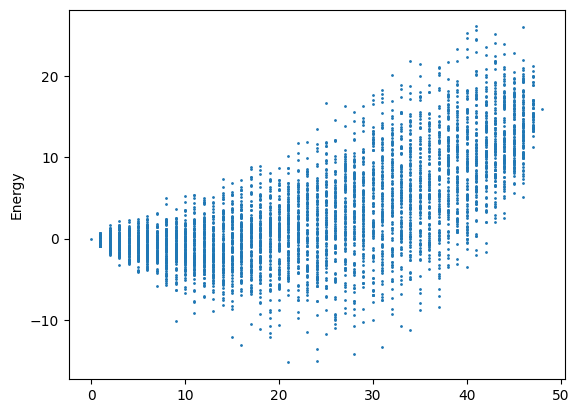

Best found: [2, 5, 6, 7, 8, 12, 13, 16, 19, 21, 22, 28, 29, 31, 33, 34, 35, 36, 40, 41, 42]
count: 21
Energy: -15.210000000000043
Solutions Sampled: 4598
Items in solution: [ 2.  8.  9. 13. 15. 23. 24. 29. 35. 38. 39. 47. 48. 50. 52. 53. 55. 58.
 65. 66. 69.]
Item Energy -15.210000000000043


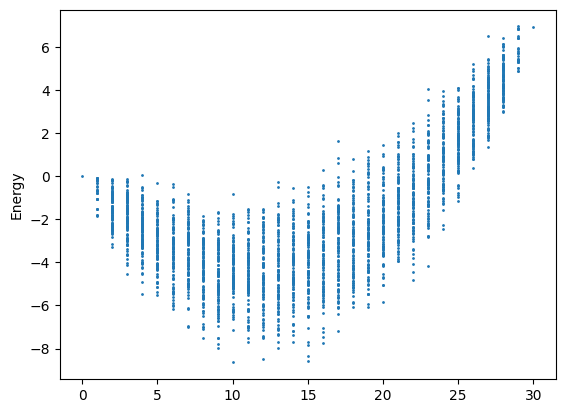

Best found: [2, 5, 6, 7, 8, 10, 11, 13, 20, 26]
count: 10
Energy: -8.646230000000001
Solutions Sampled: 2762
Ideal suppliers: [2, 5, 6, 7, 8, 10, 11, 13, 20, 26]
Supplier energy -8.646230000000001
Items available: 39 [ 0  1  2  3  9 14 16 17 22 24 25 26 28 29 30 32 33 34 35 36 37 38 39 40
 42 44 45 46 48 55 57 58 63 66 74 76 77 78 79]
(39, 39)


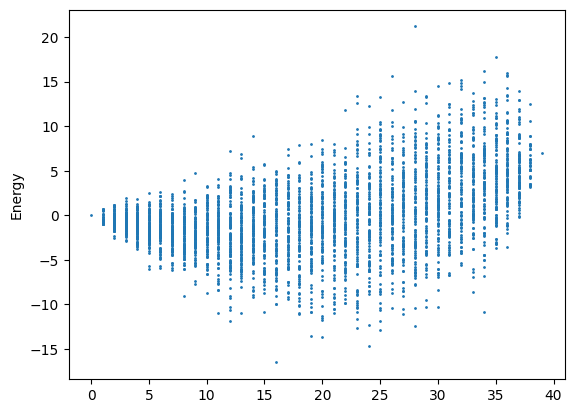

Best found: [1, 2, 3, 4, 5, 9, 11, 17, 23, 24, 25, 27, 29, 30, 31, 32]
count: 16
Energy: -16.510000000000023
Solutions Sampled: 3680
Items in solution: [ 1.  2.  3.  9. 14. 24. 26. 34. 40. 42. 44. 46. 55. 57. 58. 63.]
Item Energy -16.510000000000023


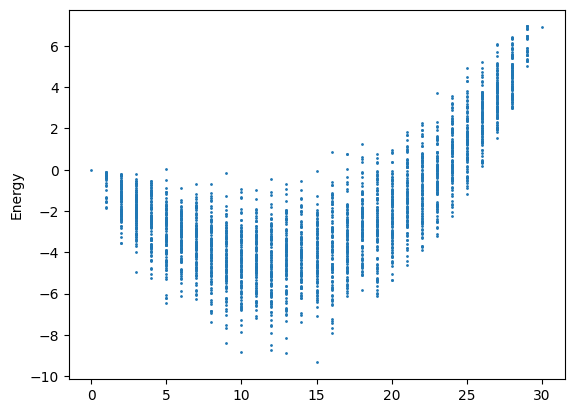

Best found: [0, 1, 5, 6, 7, 9, 10, 11, 14, 15, 16, 20, 24, 28, 29]
count: 15
Energy: -9.336070000000001
Solutions Sampled: 2762
Ideal suppliers: [0, 1, 5, 6, 7, 9, 10, 11, 14, 15, 16, 20, 24, 28, 29]
Supplier energy -9.336070000000001
Items available: 50 [ 0  1  2  3  5  9 13 14 16 17 18 19 22 24 25 29 30 31 32 35 36 38 39 40
 41 42 44 45 46 47 48 49 50 51 52 53 55 57 58 60 65 66 69 70 73 74 75 76
 77 79]
(50, 50)


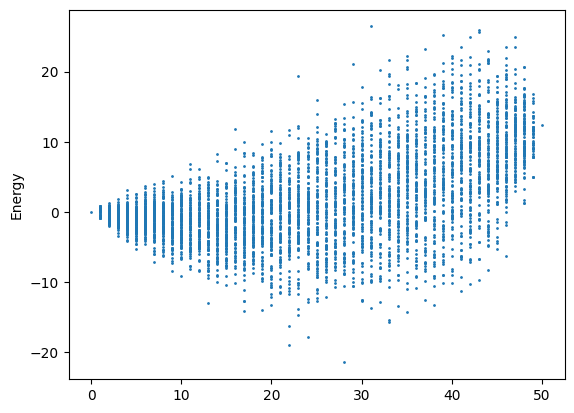

Best found: [0, 2, 4, 5, 6, 8, 11, 13, 20, 22, 23, 25, 26, 28, 29, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49]
count: 28
Energy: -21.490000000000084
Solutions Sampled: 4802
Items in solution: [ 0.  2.  5.  9. 13. 16. 19. 24. 36. 39. 40. 42. 44. 46. 47. 51. 53. 55.
 58. 60. 65. 66. 69. 70. 73. 74. 75. 79.]
Item Energy -21.490000000000084


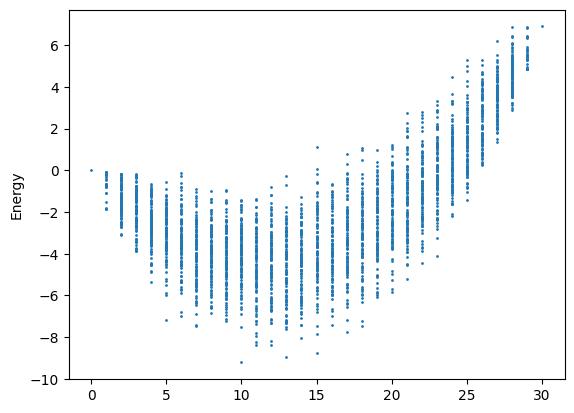

Best found: [0, 5, 6, 8, 10, 12, 14, 20, 27, 29]
count: 10
Energy: -9.2177
Solutions Sampled: 2762
Ideal suppliers: [0, 5, 6, 8, 10, 12, 14, 20, 27, 29]
Supplier energy -9.2177
Items available: 43 [ 0  1  2  3  5  9 11 22 24 25 29 30 32 33 34 35 36 37 38 39 41 42 44 45
 46 47 48 50 51 52 53 54 55 58 60 65 66 69 70 74 76 77 78]
(43, 43)


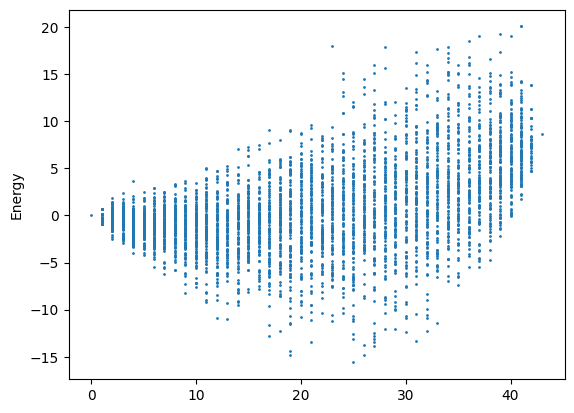

Best found: [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 17, 19, 20, 23, 25, 27, 28, 29, 32, 33, 34, 35, 37, 38, 39]
count: 25
Energy: -15.610000000000047
Solutions Sampled: 4088
Items in solution: [ 0.  1.  2.  3.  5.  9. 11. 25. 29. 34. 37. 39. 41. 45. 47. 50. 51. 52.
 55. 58. 60. 65. 69. 70. 74.]
Item Energy -15.610000000000047


In [58]:

plot_sup1=[]
plot_prod1=[]

total=20
for trials in range(total):

    sup_list=ProbabilisticSampler(Ms,100)
    print('Ideal suppliers:',sup_list[0])
    #print('count', len(sup_list[0]))
    print('Supplier energy', sup_list[1])
    plot_sup1.append(sup_list[1])
    a=availability(sup_list[0],Ma)
    print('Items available:',len(a),a)
    m_i=item_m(a, Mi)
    print(np.shape(m_i))
    p_items=ProbabilisticSampler(m_i,100)
    i_item=np.zeros(len(p_items[0]))
    for i in range(len(p_items[0])):
        i_item[i]=a[p_items[0][i]]
    print('Items in solution:',i_item)
    #print('count', len(p_items[0]))
    print('Item Energy', p_items[1])
    plot_prod1.append(p_items[1])
    


Collecting Plotting data for Scenario B

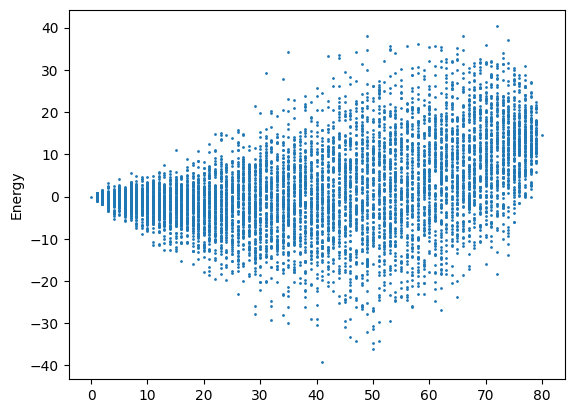

Best found: [1, 3, 4, 5, 7, 10, 11, 13, 14, 15, 18, 20, 21, 34, 38, 40, 41, 42, 43, 47, 51, 54, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 69, 70, 71, 73, 74, 75, 77, 78, 79]
count: 41
Energy: -39.28999999999969
Solutions Sampled: 7862
Ideal items: [1, 3, 4, 5, 7, 10, 11, 13, 14, 15, 18, 20, 21, 34, 38, 40, 41, 42, 43, 47, 51, 54, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 69, 70, 71, 73, 74, 75, 77, 78, 79]
Items energy: -39.28999999999969
max random 30


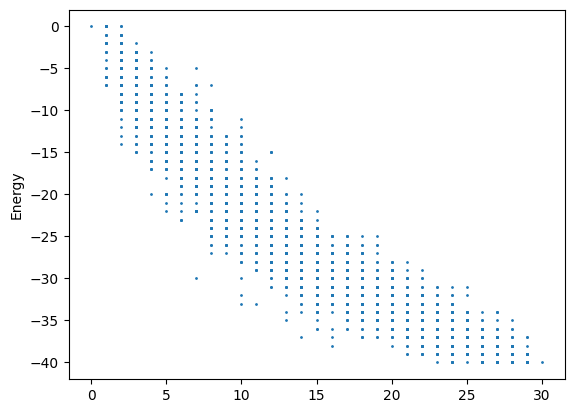

Best found: [0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
count: 23
Energy: -40.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 0.344279000000001
[0.344279000000001]


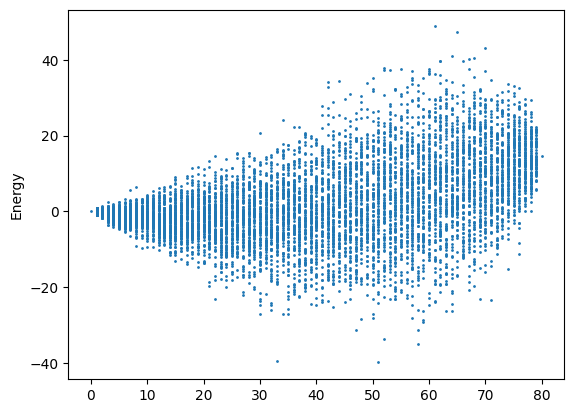

Best found: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 21, 22, 23, 25, 26, 27, 30, 34, 35, 37, 39, 41, 42, 43, 46, 47, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 65, 66, 69, 71, 72, 73, 74, 76, 77, 79]
count: 51
Energy: -39.809999999999675
Solutions Sampled: 7862
Ideal items: [0, 1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 21, 22, 23, 25, 26, 27, 30, 34, 35, 37, 39, 41, 42, 43, 46, 47, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 65, 66, 69, 71, 72, 73, 74, 76, 77, 79]
Items energy: -39.809999999999675
max random 30


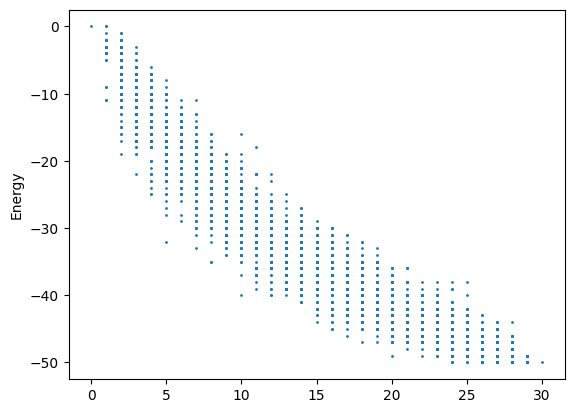

Best found: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29]
count: 24
Energy: -50.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12, 14, 15, 17, 18, 19, 20, 21, 23, 24, 25, 27, 28, 29]
Supplier Energy 0.3135340000000001
[0.344279000000001, 0.3135340000000001]


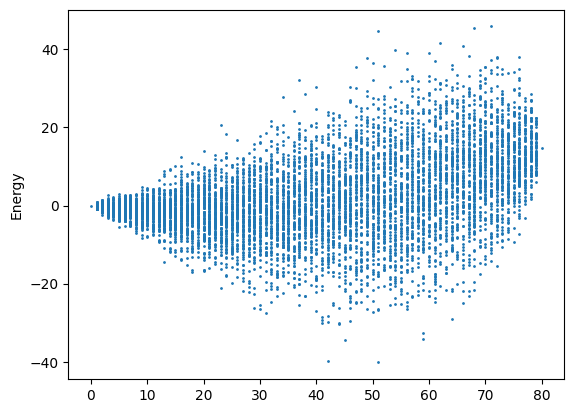

Best found: [0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 19, 23, 24, 25, 26, 27, 29, 30, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 67, 69, 70, 71, 72, 73, 76]
count: 51
Energy: -40.159999999999826
Solutions Sampled: 7862
Ideal items: [0, 1, 3, 4, 5, 6, 7, 9, 11, 12, 13, 15, 16, 19, 23, 24, 25, 26, 27, 29, 30, 33, 34, 35, 36, 39, 40, 41, 43, 44, 45, 46, 47, 49, 52, 53, 54, 55, 56, 57, 58, 61, 62, 63, 67, 69, 70, 71, 72, 73, 76]
Items energy: -40.159999999999826
max random 30


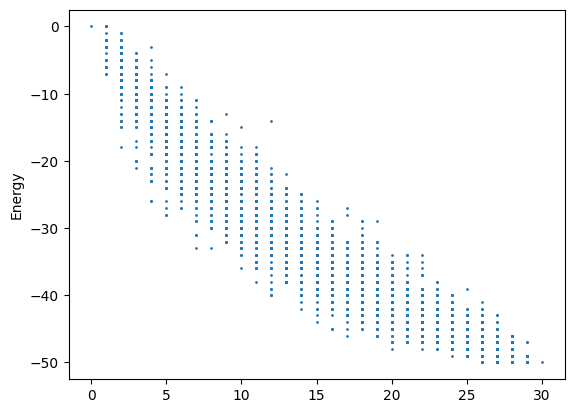

Best found: [0, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
count: 26
Energy: -50.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 3.1220790000000047
[0.344279000000001, 0.3135340000000001, 3.1220790000000047]


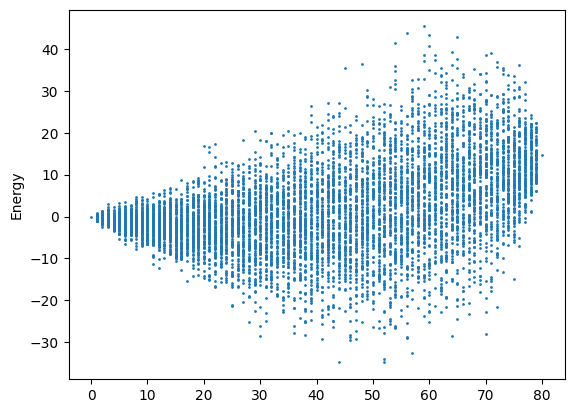

Best found: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 20, 21, 24, 25, 26, 27, 30, 33, 34, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 62, 63, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 78, 79]
count: 52
Energy: -34.83999999999963
Solutions Sampled: 7862
Ideal items: [2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 16, 20, 21, 24, 25, 26, 27, 30, 33, 34, 36, 38, 39, 40, 42, 43, 45, 46, 47, 48, 50, 52, 53, 54, 55, 56, 57, 58, 62, 63, 65, 66, 67, 69, 70, 71, 72, 74, 75, 76, 78, 79]
Items energy: -34.83999999999963
max random 30


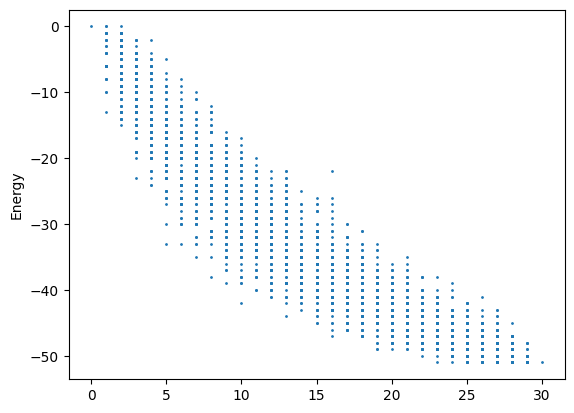

Best found: [0, 2, 3, 4, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28]
count: 23
Energy: -51.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 6, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28]
Supplier Energy 0.4779440000000018
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018]


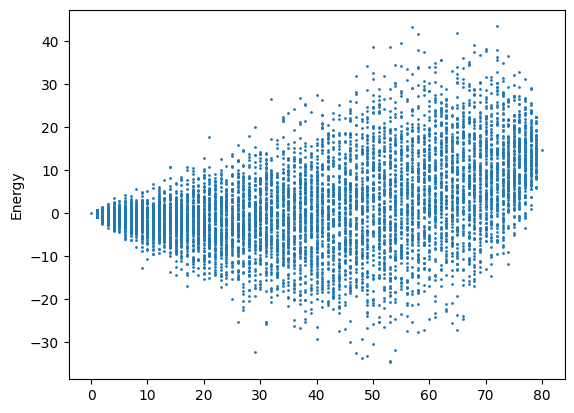

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 29, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 51, 52, 53, 54, 56, 57, 58, 59, 60, 63, 65, 66, 69, 70, 71, 77]
count: 53
Energy: -34.699999999999726
Solutions Sampled: 7862
Ideal items: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 23, 25, 27, 29, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 51, 52, 53, 54, 56, 57, 58, 59, 60, 63, 65, 66, 69, 70, 71, 77]
Items energy: -34.699999999999726
max random 30


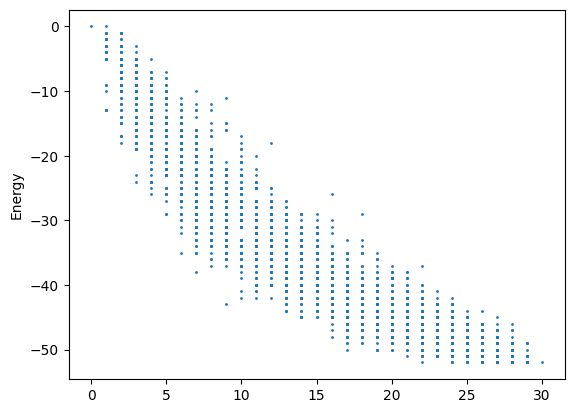

Best found: [0, 1, 2, 4, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28]
count: 22
Energy: -52.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 4, 8, 9, 10, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28]
Supplier Energy 1.0628240000000027
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027]


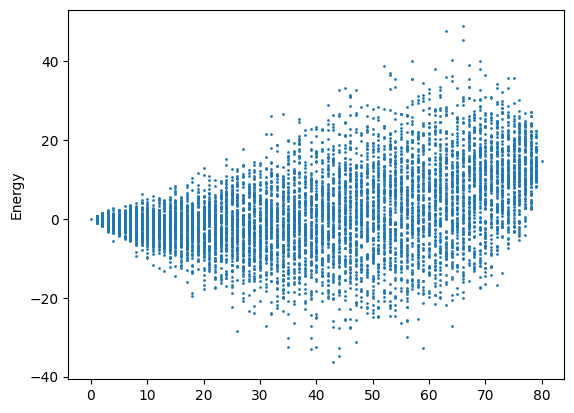

Best found: [0, 5, 7, 8, 9, 10, 11, 12, 13, 15, 19, 22, 23, 25, 26, 30, 34, 35, 36, 37, 39, 40, 43, 46, 48, 52, 53, 56, 57, 58, 59, 60, 61, 66, 67, 69, 71, 73, 74, 76, 77, 78, 79]
count: 43
Energy: -36.429999999999566
Solutions Sampled: 7862
Ideal items: [0, 5, 7, 8, 9, 10, 11, 12, 13, 15, 19, 22, 23, 25, 26, 30, 34, 35, 36, 37, 39, 40, 43, 46, 48, 52, 53, 56, 57, 58, 59, 60, 61, 66, 67, 69, 71, 73, 74, 76, 77, 78, 79]
Items energy: -36.429999999999566
max random 30


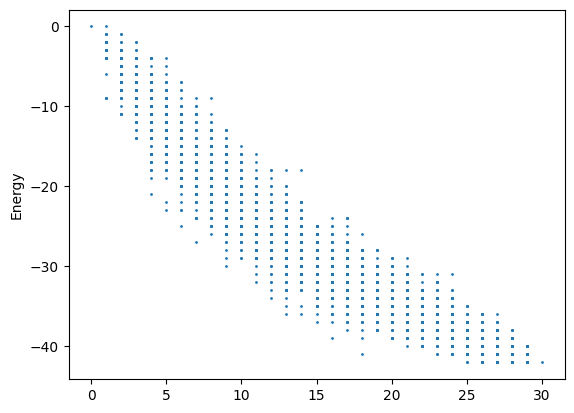

Best found: [0, 2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
count: 25
Energy: -42.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
Supplier Energy 3.596204000000006
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006]


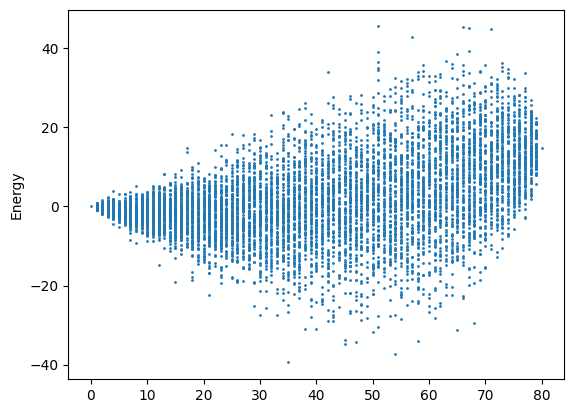

Best found: [4, 5, 8, 10, 11, 13, 14, 15, 19, 21, 24, 25, 26, 32, 33, 37, 38, 40, 42, 46, 47, 48, 50, 52, 54, 55, 56, 62, 63, 69, 70, 71, 72, 73, 79]
count: 35
Energy: -39.45999999999998
Solutions Sampled: 7862
Ideal items: [4, 5, 8, 10, 11, 13, 14, 15, 19, 21, 24, 25, 26, 32, 33, 37, 38, 40, 42, 46, 47, 48, 50, 52, 54, 55, 56, 62, 63, 69, 70, 71, 72, 73, 79]
Items energy: -39.45999999999998
max random 30


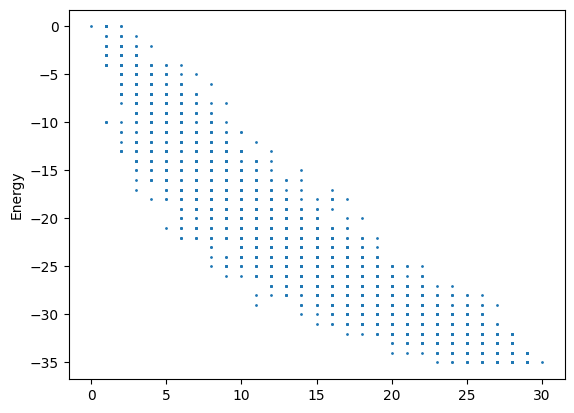

Best found: [0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29]
count: 23
Energy: -35.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 3, 4, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 21, 23, 24, 26, 27, 29]
Supplier Energy 1.1781740000000012
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012]


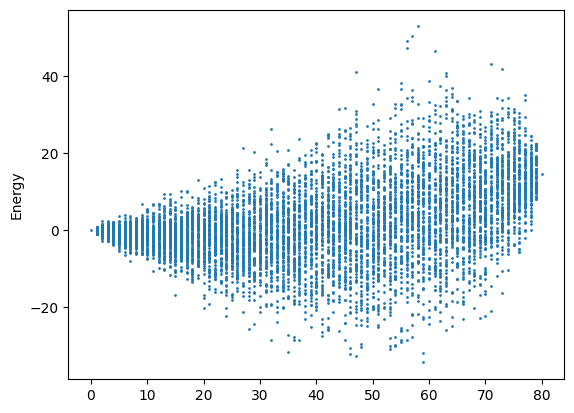

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 24, 25, 26, 27, 29, 31, 33, 34, 37, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 77]
count: 59
Energy: -34.349999999999746
Solutions Sampled: 7862
Ideal items: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 21, 22, 24, 25, 26, 27, 29, 31, 33, 34, 37, 39, 40, 42, 43, 44, 45, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 69, 70, 71, 72, 73, 74, 75, 77]
Items energy: -34.349999999999746
max random 30


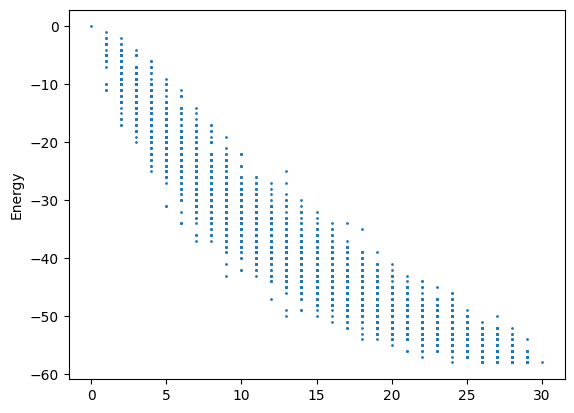

Best found: [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28]
count: 24
Energy: -58.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Supplier Energy 0.6351090000000005
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005]


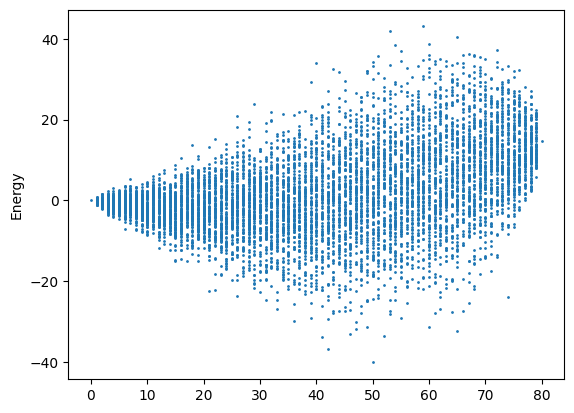

Best found: [0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 26, 28, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 47, 49, 50, 55, 56, 57, 58, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79]
count: 50
Energy: -40.04999999999967
Solutions Sampled: 7862
Ideal items: [0, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 26, 28, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 47, 49, 50, 55, 56, 57, 58, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 77, 78, 79]
Items energy: -40.04999999999967
max random 30


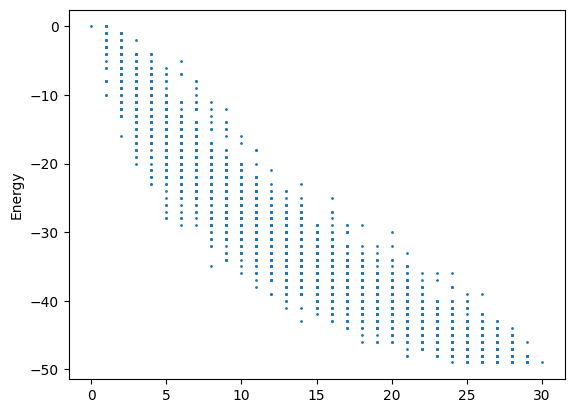

Best found: [0, 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
count: 24
Energy: -49.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 5, 8, 9, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Supplier Energy 1.059933
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933]


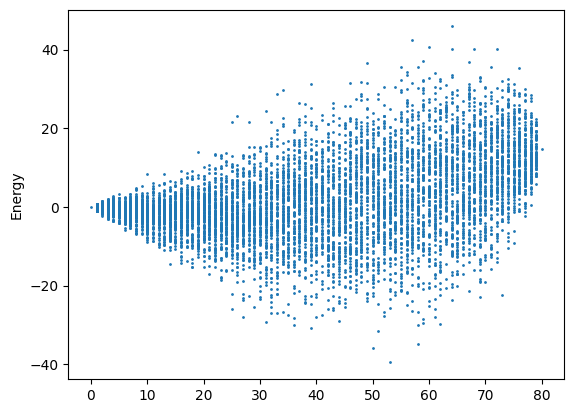

Best found: [0, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 17, 18, 21, 24, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 46, 47, 48, 49, 54, 55, 56, 57, 58, 60, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]
count: 53
Energy: -39.549999999999685
Solutions Sampled: 7862
Ideal items: [0, 2, 3, 4, 5, 7, 8, 10, 11, 13, 14, 15, 17, 18, 21, 24, 27, 28, 30, 31, 33, 34, 36, 37, 38, 39, 40, 42, 43, 46, 47, 48, 49, 54, 55, 56, 57, 58, 60, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]
Items energy: -39.549999999999685
max random 30


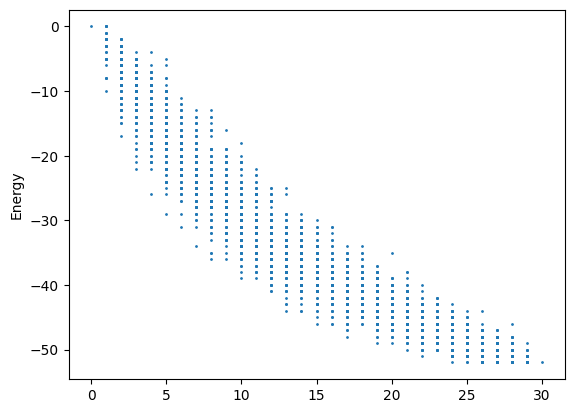

Best found: [0, 1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
count: 24
Energy: -52.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy -0.94158
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158]


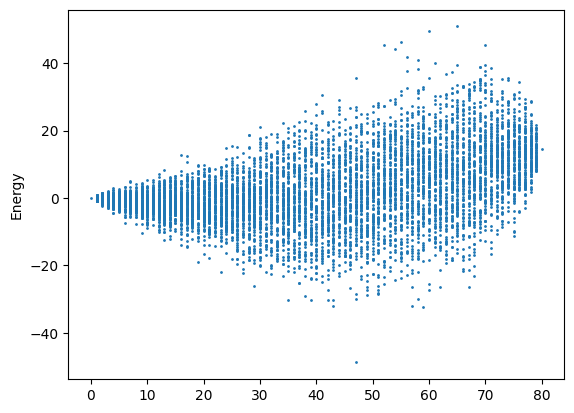

Best found: [2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 70, 71, 72, 73, 74, 76]
count: 47
Energy: -48.81999999999984
Solutions Sampled: 7862
Ideal items: [2, 4, 5, 6, 7, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 70, 71, 72, 73, 74, 76]
Items energy: -48.81999999999984
max random 30


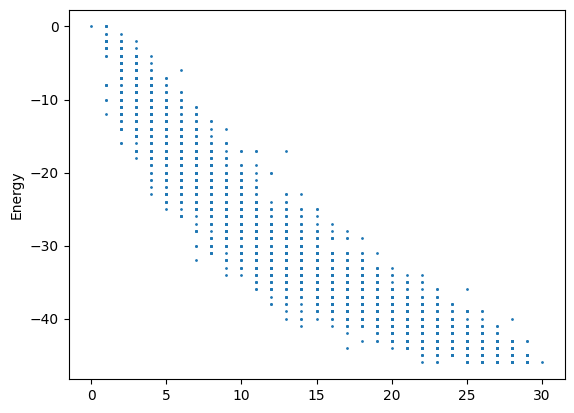

Best found: [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27]
count: 22
Energy: -46.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 3, 4, 5, 8, 9, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 26, 27]
Supplier Energy 1.138583000000002
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002]


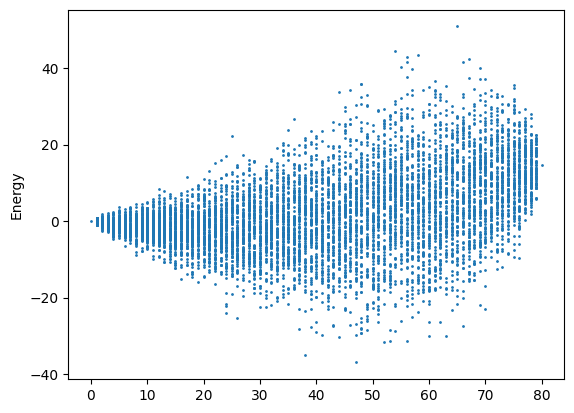

Best found: [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 18, 22, 23, 25, 26, 33, 34, 38, 39, 40, 41, 42, 46, 47, 49, 50, 51, 53, 55, 56, 58, 59, 61, 62, 63, 66, 67, 69, 70, 72, 74, 75, 77, 78, 79]
count: 47
Energy: -36.969999999999544
Solutions Sampled: 7862
Ideal items: [1, 2, 3, 4, 5, 6, 7, 9, 11, 12, 13, 16, 18, 22, 23, 25, 26, 33, 34, 38, 39, 40, 41, 42, 46, 47, 49, 50, 51, 53, 55, 56, 58, 59, 61, 62, 63, 66, 67, 69, 70, 72, 74, 75, 77, 78, 79]
Items energy: -36.969999999999544
max random 30


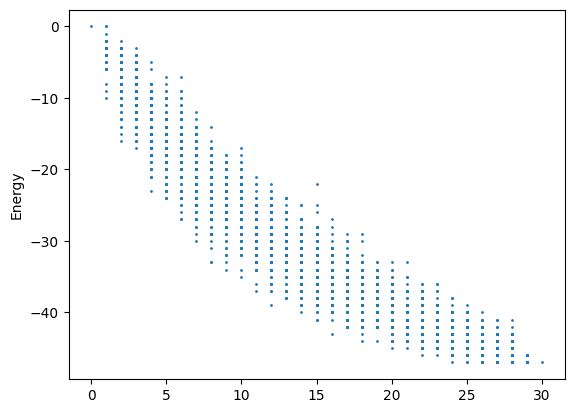

Best found: [0, 2, 3, 4, 5, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]
count: 24
Energy: -47.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 5, 7, 8, 10, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 0.6041240000000013
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013]


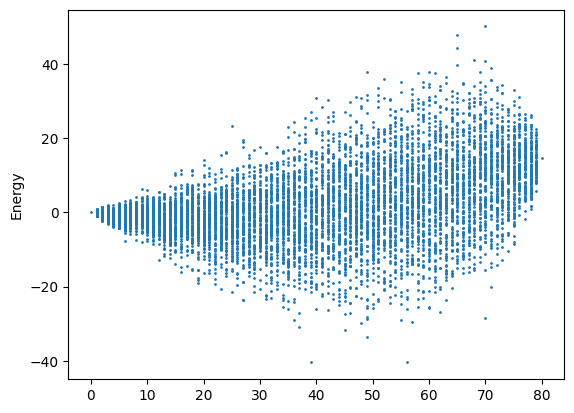

Best found: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73]
count: 56
Energy: -40.4199999999994
Solutions Sampled: 7862
Ideal items: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 16, 19, 21, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 61, 62, 65, 66, 67, 68, 69, 70, 71, 72, 73]
Items energy: -40.4199999999994
max random 30


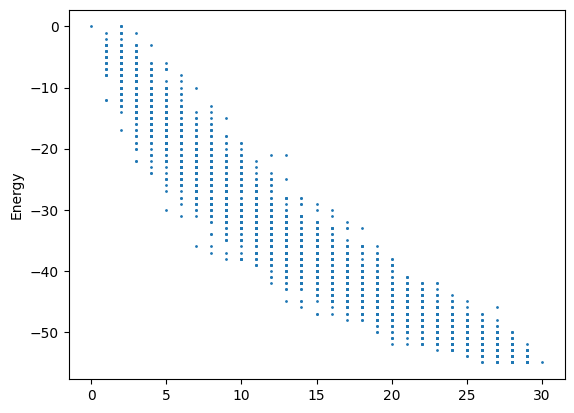

Best found: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
count: 26
Energy: -55.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 1.364243000000001
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001]


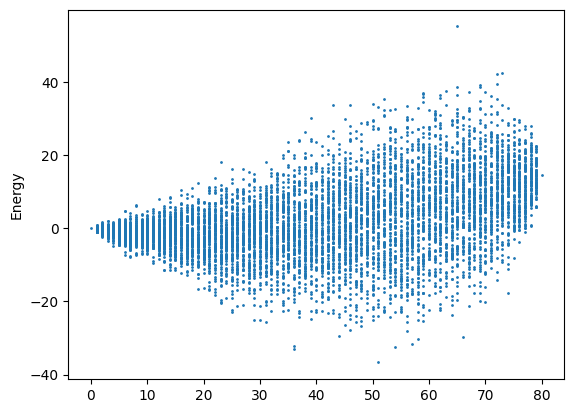

Best found: [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 24, 26, 27, 31, 33, 37, 38, 39, 41, 42, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 66, 67, 68, 69, 70, 71, 72, 74, 77, 78, 79]
count: 51
Energy: -36.66999999999952
Solutions Sampled: 7862
Ideal items: [1, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 24, 26, 27, 31, 33, 37, 38, 39, 41, 42, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 66, 67, 68, 69, 70, 71, 72, 74, 77, 78, 79]
Items energy: -36.66999999999952
max random 30


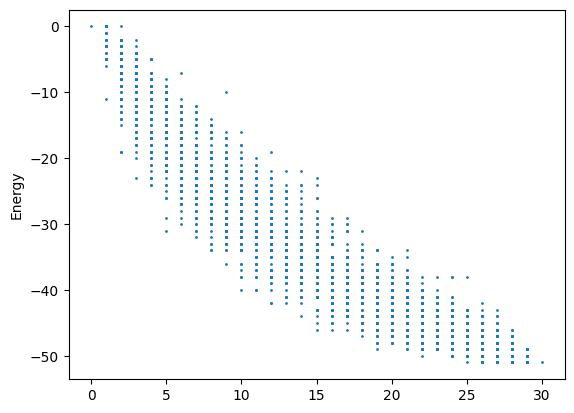

Best found: [0, 2, 3, 4, 6, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
count: 25
Energy: -51.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 6, 8, 9, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 2.2118130000000034
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034]


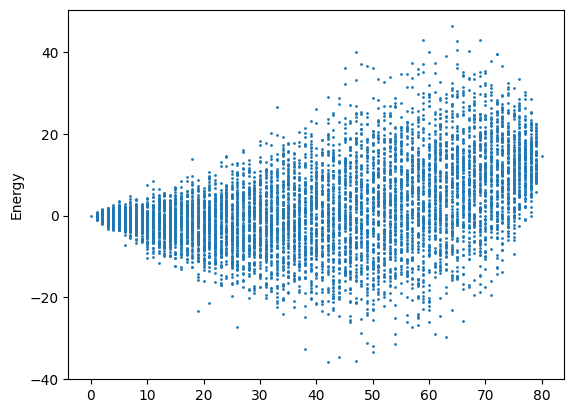

Best found: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 19, 20, 25, 26, 28, 29, 31, 37, 38, 39, 40, 41, 42, 44, 47, 49, 52, 53, 55, 56, 57, 58, 65, 66, 67, 71, 72, 74, 75]
count: 42
Energy: -35.97999999999996
Solutions Sampled: 7862
Ideal items: [0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 19, 20, 25, 26, 28, 29, 31, 37, 38, 39, 40, 41, 42, 44, 47, 49, 52, 53, 55, 56, 57, 58, 65, 66, 67, 71, 72, 74, 75]
Items energy: -35.97999999999996
max random 30


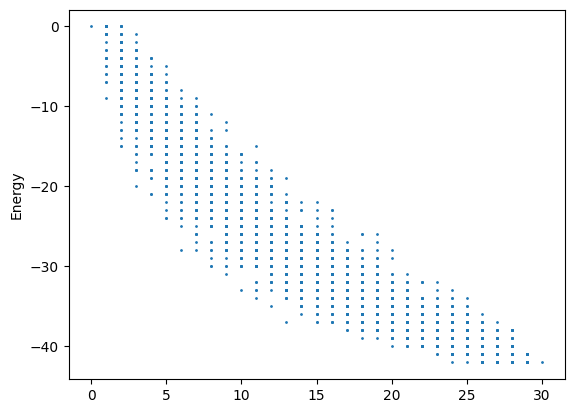

Best found: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
count: 24
Energy: -42.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 5, 6, 7, 9, 10, 11, 13, 14, 16, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy -1.1340309999999993
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993]


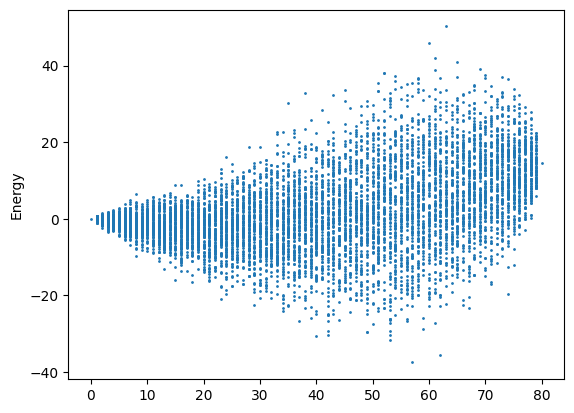

Best found: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 25, 26, 28, 34, 35, 36, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 55, 57, 58, 59, 61, 62, 63, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79]
count: 57
Energy: -37.489999999999554
Solutions Sampled: 7862
Ideal items: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 23, 25, 26, 28, 34, 35, 36, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 53, 55, 57, 58, 59, 61, 62, 63, 65, 66, 67, 69, 70, 72, 73, 74, 75, 76, 77, 78, 79]
Items energy: -37.489999999999554
max random 30


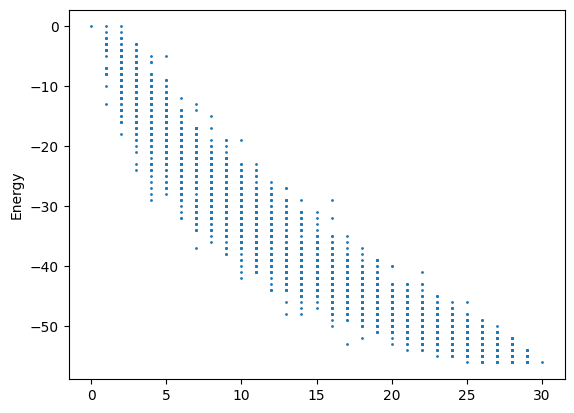

Best found: [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
count: 25
Energy: -56.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy 2.0154590000000066
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066]


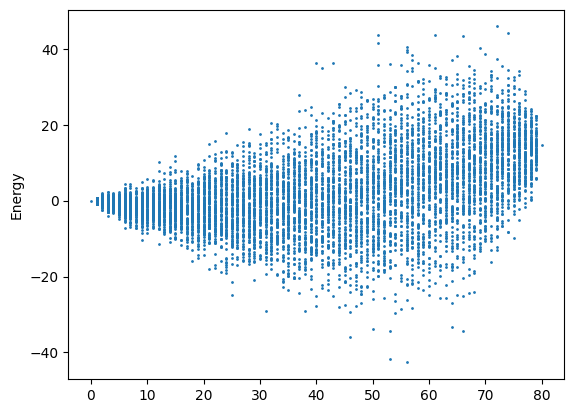

Best found: [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 65, 66, 67, 69, 70, 71, 73, 74, 75]
count: 56
Energy: -42.6399999999995
Solutions Sampled: 7862
Ideal items: [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 29, 33, 34, 35, 36, 39, 40, 41, 42, 43, 45, 46, 48, 50, 51, 53, 54, 55, 56, 57, 58, 59, 62, 63, 65, 66, 67, 69, 70, 71, 73, 74, 75]
Items energy: -42.6399999999995
max random 30


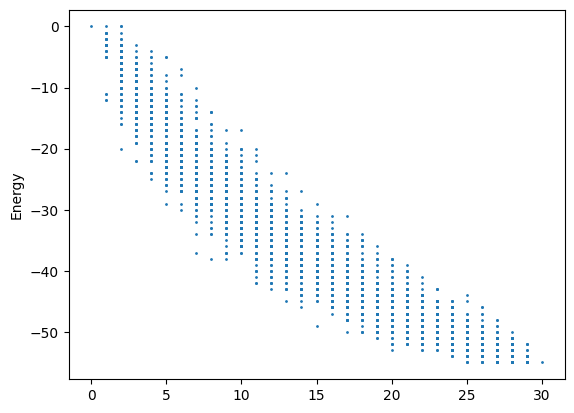

Best found: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29]
count: 25
Energy: -55.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 3, 4, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 24, 25, 26, 27, 29]
Supplier Energy 2.652033000000008
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066, 2.652033000000008]


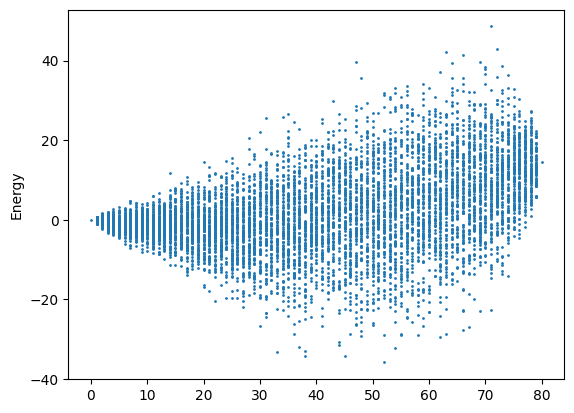

Best found: [2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 20, 21, 22, 23, 24, 26, 27, 28, 32, 33, 34, 36, 37, 39, 40, 43, 46, 48, 49, 52, 53, 54, 55, 57, 58, 59, 60, 63, 65, 66, 68, 69, 70, 72, 73, 74, 76, 78, 79]
count: 52
Energy: -35.85999999999965
Solutions Sampled: 7862
Ideal items: [2, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 17, 20, 21, 22, 23, 24, 26, 27, 28, 32, 33, 34, 36, 37, 39, 40, 43, 46, 48, 49, 52, 53, 54, 55, 57, 58, 59, 60, 63, 65, 66, 68, 69, 70, 72, 73, 74, 76, 78, 79]
Items energy: -35.85999999999965
max random 30


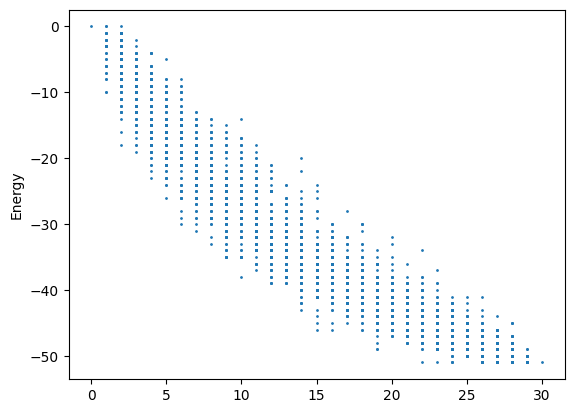

Best found: [0, 2, 4, 5, 7, 8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29]
count: 22
Energy: -51.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 4, 5, 7, 8, 10, 11, 12, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 29]
Supplier Energy -2.6933460000000005
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066, 2.652033000000008, -2.6933460000000005]


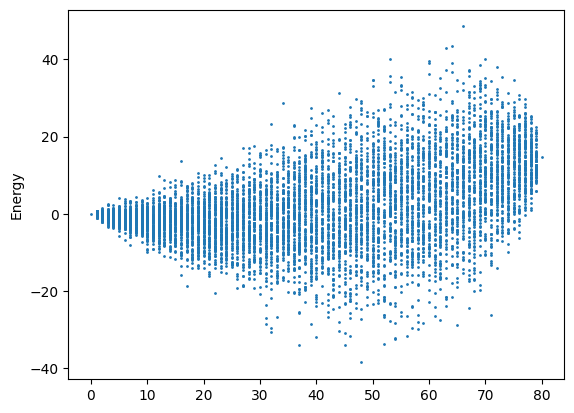

Best found: [3, 9, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 29, 30, 33, 34, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 67, 69, 70, 71, 72, 73, 74]
count: 48
Energy: -38.54999999999986
Solutions Sampled: 7862
Ideal items: [3, 9, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 25, 26, 29, 30, 33, 34, 36, 37, 38, 39, 40, 41, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 67, 69, 70, 71, 72, 73, 74]
Items energy: -38.54999999999986
max random 30


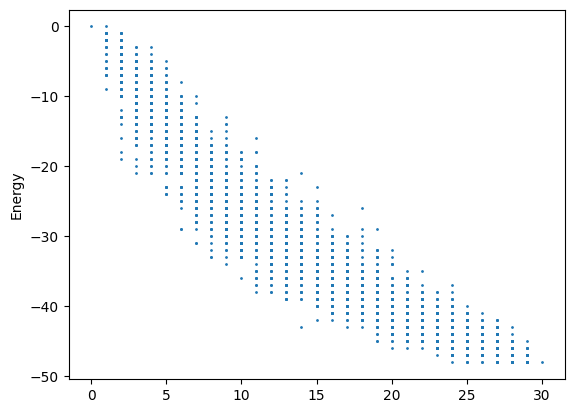

Best found: [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
count: 24
Energy: -48.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 1, 2, 3, 4, 5, 7, 8, 9, 11, 12, 13, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]
Supplier Energy 3.426833000000006
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066, 2.652033000000008, -2.6933460000000005, 3.426833000000006]


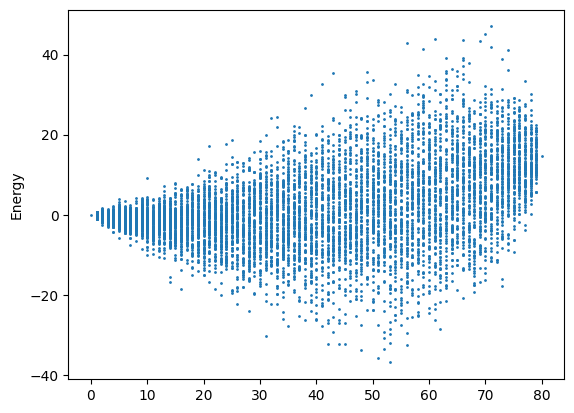

Best found: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 26, 29, 30, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 47, 48, 52, 55, 56, 57, 58, 61, 62, 64, 65, 66, 67, 69, 70, 72, 73, 74, 76]
count: 53
Energy: -36.88999999999981
Solutions Sampled: 7862
Ideal items: [0, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 23, 24, 26, 29, 30, 32, 33, 34, 36, 38, 39, 40, 41, 42, 43, 45, 47, 48, 52, 55, 56, 57, 58, 61, 62, 64, 65, 66, 67, 69, 70, 72, 73, 74, 76]
Items energy: -36.88999999999981
max random 30


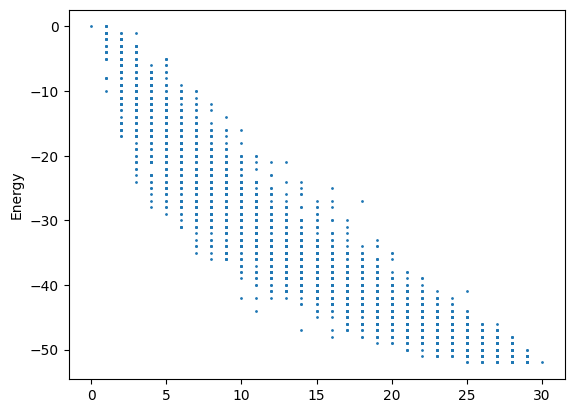

Best found: [0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
count: 25
Energy: -52.0
Solutions Sampled: 2762
Min Suppliers to cover items: [0, 2, 3, 4, 6, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 29]
Supplier Energy 2.8569130000000054
[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066, 2.652033000000008, -2.6933460000000005, 3.426833000000006, 2.8569130000000054]


In [59]:

plot_sup2=[]
plot_prod2=[]
total=20
for trials in range(total):
    #ideal items from Mi
    p_items=ProbabilisticSampler(Mi,100)
    print('Ideal items:', p_items[0])
    print('Items energy:', p_items[1])
    plot_prod2.append(p_items[1])
    # now find suppliers that cover these items:
    # this is a set cover problem
    
    sup_list=SetCoverSampler(Ma,p_items[0],100)
    print('Min Suppliers to cover items:',sup_list[0])
    sup_energy=0
    for i in sup_list[0]:
        for j in sup_list[0]:
            if i<=j:
                sup_energy+=Ms[i,j]
    print('Supplier Energy',sup_energy)
    
    plot_sup2.append(sup_energy)
    print(plot_sup2)

In [60]:
print(plot_sup2)

[0.344279000000001, 0.3135340000000001, 3.1220790000000047, 0.4779440000000018, 1.0628240000000027, 3.596204000000006, 1.1781740000000012, 0.6351090000000005, 1.059933, -0.94158, 1.138583000000002, 0.6041240000000013, 1.364243000000001, 2.2118130000000034, -1.1340309999999993, 2.0154590000000066, 2.652033000000008, -2.6933460000000005, 3.426833000000006, 2.8569130000000054]


Text(0.5, 1.0, 'Find optimal supplier and product')

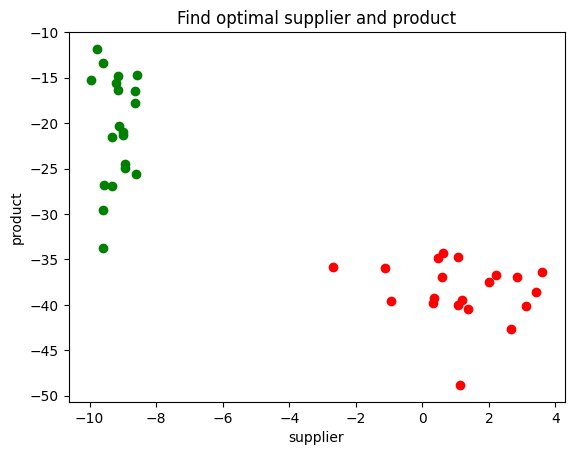

In [61]:
# now plot
#figure(figsize=(10, 6), dpi=100)
plt.scatter(plot_sup1,plot_prod1,color='green')
plt.scatter(plot_sup2,plot_prod2,color='red')
            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')

## Evaluate the optimal values using D-Wave annealer

In [ ]:
# Optimizing for Scenario A

In [64]:
dwave_plot_sup1=[]
dwave_plot_prod1=[]

sup_result=run_dwave(Ms,0.5)

26843545600
chain strength: 6.0 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 ... 29     energy num_oc. ...
0     1  0  0  1  0  1  1  1  0  0  1  1  0  0  1 ...  1 -10.547531       1 ...
1     0  0  0  0  0  1  1  1  0  1  1  1  0  0  1 ...  1   -9.68537       1 ...
2     1  0  0  0  0  1  1  1  0  0  1  0  0  0  1 ...  0   -9.65641       1 ...
3     1  0  0  0  0  1  0  1  1  1  1  1  0  0  1 ...  0   -9.61636       1 ...
4     1  0  0  0  1  1  1  1  1  1  0  1  0  0  1 ...  0   -9.59472       1 ...
5     1  0  0  0  0  1  1  1  1  0  1  1  0  0  1 ...  1   -9.49411       1 ...
6     1  0  0  1  1  1  1  1  1  0  1  0  1  0  1 ...  1   -9.47295       1 ...
7     1  0  0  0  0  1  0  1  0  0  1  0  1  0  1 ...  1   -9.45385       1 ...
8     1  0  0  0  1  1  1  1  1  0  0  0  0  0  1 ...  0   -9.36219       1 ...
9     0  1  0  0  1  1  1  1  1  0  1  0  0  1  1 ...  1   -9.31216       1 ...
10    1  0  0  0  0  1  0  1  0  1  0  1  0  1  1 ...  0   -9.28772       1 

In [65]:
i=sup_result.first
print(i)
print(i.sample[0])

Sample(sample={0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 1, 11: 1, 12: 0, 13: 0, 14: 1, 15: 0, 16: 0, 17: 0, 18: 0, 19: 0, 20: 1, 21: 0, 22: 0, 23: 0, 24: 0, 25: 0, 26: 0, 27: 0, 28: 1, 29: 1}, energy=-10.547531, num_occurrences=1, chain_break_fraction=0.0)
1


In [66]:
first_sup=sup_result.first    
sup_list=[]
for s in range(len(Ms)):
    if first_sup.sample[s]==1:
        sup_list.append(s)
print(sup_list)
print('Supplier energy', first_sup[1])
dwave_plot_sup1.append(first_sup[1])    
a=availability(sup_list,Ma)
print('Items available:',len(a),a)   
m_i=item_m(a, Mi)
print(np.shape(m_i))
item_result=run_dwave(m_i,0.5)

[0, 3, 5, 6, 7, 10, 11, 14, 20, 28, 29]
Supplier energy -10.547531
Items available: 43 [ 0  1  2  3  5  9 16 17 22 25 29 31 32 35 36 38 39 40 41 42 44 45 46 47
 48 49 50 51 52 53 55 58 59 60 61 65 66 69 70 74 76 77 79]
(43, 43)
219902325555200
chain strength: 8.6 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 42 energy num_oc. ...
2294  0  0  1  1  0  1  0  0  1  1  1  1  0  0  0  1 ...  0 -14.83       1 ...
0     1  0  1  1  0  1  0  0  0  1  0  0  0  0  0  0 ...  0 -14.31       1 ...
1     0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  1 ...  0  -13.3       1 ...
2     0  1  1  0  0  1  1  0  1  1  0  0  0  0  0  1 ...  1 -13.28       1 ...
3     0  0  1  1  0  1  1  0  0  1  0  0  0  0  1  0 ...  0 -13.14       1 ...
4     1  1  1  1  0  1  1  0  0  0  0  0  0  0  0  0 ...  0 -13.14       1 ...
5     1  0  1  0  0  1  0  1  0  1  0  0  0  0  1  0 ...  0 -13.07       1 ...
6     0  0  1  1  0  1  1  0  0  1  0  0  0  0  0  0 ...  0  -12.9       1 ...
7     0  1  1

In [67]:
print(item_result.first)

Sample(sample={0: 0, 1: 0, 2: 1, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 1, 10: 1, 11: 1, 12: 0, 13: 0, 14: 0, 15: 1, 16: 1, 17: 1, 18: 0, 19: 0, 20: 0, 21: 0, 22: 1, 23: 0, 24: 1, 25: 0, 26: 0, 27: 0, 28: 0, 29: 1, 30: 1, 31: 1, 32: 0, 33: 1, 34: 0, 35: 0, 36: 0, 37: 1, 38: 1, 39: 1, 40: 0, 41: 0, 42: 0}, energy=-14.830000000000043, num_occurrences=1, chain_break_fraction=0.023255813953488372)


In [68]:
first_item=item_result.first
itm_list=[]
for s in range(len(m_i)):
    if first_item.sample[s]==1:
        itm_list.append(s)
print('items:',itm_list)
i_item=np.zeros(len(itm_list))
for i in range(len(itm_list)):
    i_item[i]=a[itm_list[i]]
print('Items in solution:',i_item)
#print('count', len(p_items[0]))
print('Item Energy:', first_item[1])
dwave_plot_prod1.append(first_item[1])

items: [2, 3, 5, 8, 9, 10, 11, 15, 16, 17, 22, 24, 29, 30, 31, 33, 37, 38, 39]
Items in solution: [ 2.  3.  9. 22. 25. 29. 31. 38. 39. 40. 46. 48. 53. 55. 58. 60. 69. 70.
 74.]
Item Energy: -14.830000000000043


Text(0.5, 1.0, 'Find optimal supplier and product')

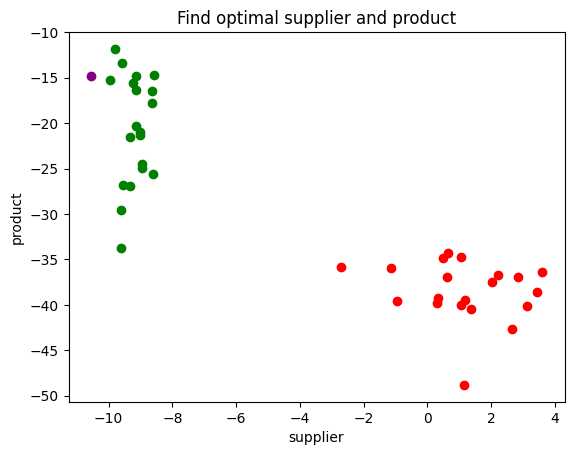

In [69]:
# now plot
#figure(figsize=(10, 6), dpi=100)
plt.scatter(dwave_plot_sup1,dwave_plot_prod1,color='purple')
# now plot
plt.scatter(plot_sup1,plot_prod1,color='green')
plt.scatter(plot_sup2,plot_prod2,color='red')
            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')

In [70]:
# Optimizing for Scenario B

In [71]:
dwave_plot_sup2=[]
dwave_plot_prod2=[]

In [72]:
#ideal items from Mi
item_results=run_dwave(Mi,0.5)

30223145490365729367654400
chain strength: 16.0 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 ... 79 energy num_oc. ...
0     0  0  1  0  1  0  1  1  0  1  1  1  1  1  0  1 ...  0 -45.48       1 ...
2602  0  1  1  1  1  1  1  1  1  1  1  1  0  1  1  1 ...  1 -43.94       1 ...
1     0  1  0  0  1  1  0  1  0  1  1  1  1  1  1  1 ...  0 -43.02       1 ...
788   0  1  1  1  0  1  1  1  0  1  1  1  0  1  1  1 ...  0  -41.4       1 ...
2     1  0  1  0  0  1  1  0  1  1  1  1  1  1  0  1 ...  0 -40.86       1 ...
859   1  1  0  0  0  0  1  1  1  1  1  1  0  1  1  1 ...  1 -40.81       1 ...
815   1  0  1  1  1  1  1  1  1  1  1  1  1  0  1  1 ...  0 -40.76       1 ...
791   1  0  1  1  1  0  0  1  1  0  1  1  1  0  1  1 ...  0 -40.67       1 ...
873   0  0  1  0  1  1  1  0  1  1  1  1  1  0  1  0 ...  0  -39.7       1 ...
936   0  0  0  1  0  1  0  0  1  1  1  1  0  0  1  1 ...  1 -38.23       1 ...
3     1  1  1  0  1  0  1  0  1  1  1  1  0  0  1  1 ...  0 -37.83     

In [73]:
first_item=item_results.first
itm_list=[]
for s in range(len(Mi)):
    if first_item.sample[s]==1:
        itm_list.append(s)
print('items:',itm_list)
print('Supplier energy', first_item[1])
dwave_plot_prod2.append(first_item[1])

items: [2, 4, 6, 7, 9, 10, 11, 12, 13, 15, 23, 24, 25, 26, 27, 28, 30, 33, 35, 36, 38, 39, 40, 41, 43, 45, 50, 51, 55, 56, 57, 58, 62, 63, 69, 70, 72, 73, 74, 76]
Supplier energy -45.4799999999998


max random 30


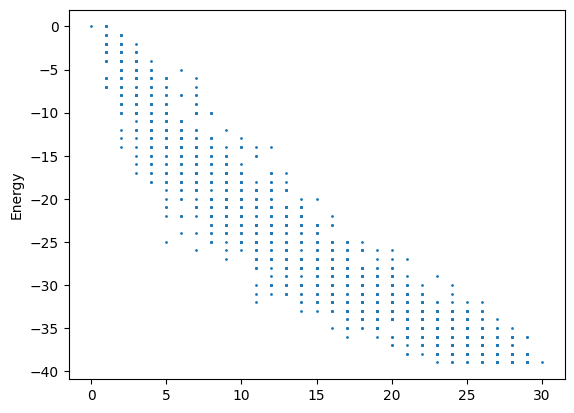

Best found: [0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
count: 23
Energy: -39.0
Solutions Sampled: 1412


In [74]:
sup_list=SetCoverSampler(Ma,itm_list,50)

In [75]:
print('Min Suppliers to cover items:',sup_list[0])
sup_energy=0
for i in sup_list[0]:
    for j in sup_list[0]:
        if i<=j:
            sup_energy+=Ms[i,j]
print('Supplier Energy',sup_energy)

dwave_plot_sup2.append(sup_energy)

Min Suppliers to cover items: [0, 1, 2, 4, 5, 7, 8, 9, 11, 12, 13, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
Supplier Energy -1.3446499999999983


Text(0.5, 1.0, 'Find optimal supplier and product')

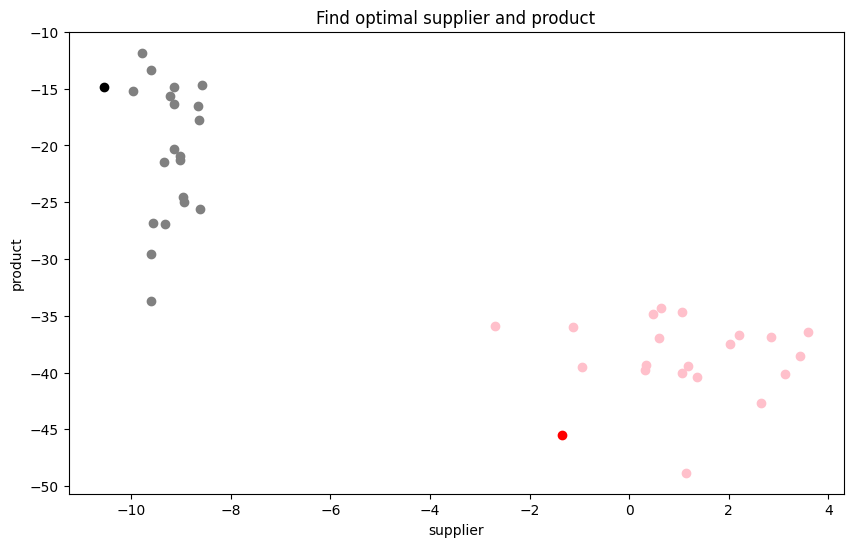

In [76]:
# now plot
figure(figsize=(10, 6), dpi=100)
plt.scatter(dwave_plot_sup1,dwave_plot_prod1,color='black')
plt.scatter(dwave_plot_sup2,dwave_plot_prod2,color='red')
# now plot
plt.scatter(plot_sup1,plot_prod1,color='gray')
plt.scatter(plot_sup2,plot_prod2,color='pink')
            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')

## Determine a better global solution

### Evaluate with the classical probabilistic solver

In [77]:
A=0.5
S=2.5
I=0.5

Ma2=Ma.copy()
Ma2 = np.where(Ma2==1, -A, 0)
print(Ma2)
print(np.shape(Ma2))

[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 ...
 [-0.5  0.   0.  ...  0.   0.   0. ]
 [-0.5  0.  -0.5 ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]
(30, 80)


In [78]:
Mz=np.zeros([len(Mi),len(Ms)],dtype=float)
print('Mz',np.shape(Mz))
Msz=np.append(S*Ms, Mz, axis=0)
print('Msz',np.shape(Msz))

Mai=np.append(Ma2, I*Mi, axis=0)
print('Mai',np.shape(Mai))

Mf=np.append(Msz,Mai, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')

Mz (80, 30)
Msz (110, 30)
Mai (110, 80)
Mf (110, 110)
[[-3.25     0.08375  0.12275 ...  0.       0.       0.     ]
 [ 0.      -0.415    0.23575 ... -0.5      0.       0.     ]
 [ 0.       0.      -0.365   ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ... -0.195    0.35     0.01   ]
 [ 0.       0.       0.      ...  0.       0.1     -0.45   ]
 [ 0.       0.       0.      ...  0.       0.      -0.17   ]]


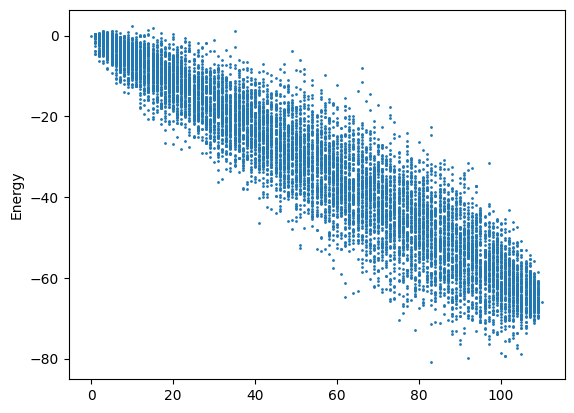

Best found: [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 28, 30, 31, 33, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 50, 52, 53, 54, 55, 56, 57, 59, 64, 65, 66, 67, 68, 69, 70, 71, 72, 74, 76, 77, 78, 79, 80, 82, 83, 84, 85, 86, 87, 88, 90, 92, 94, 95, 96, 98, 99, 100, 102, 103, 104, 107, 108, 109]
count: 83
Energy: -80.94629999999998
Solutions Sampled: 10902


In [79]:
result=ProbabilisticSampler(Mf,100)

In [80]:
sup_list=[]
item_list=[]
for i in (result[0]):
    if i<len(Ms):
        sup_list.append(i)
    else:
        item_list.append(i-len(Ms))

print(sup_list)

sup_energy=0
for i in sup_list:
    for j in sup_list:
        if i<=j:
            sup_energy+=Ms[i,j]
print('Supplier Energy',sup_energy)

print(item_list)

item_energy=0
for i in item_list:
    for j in item_list:
        if i<=j:
            item_energy+=Mi[i,j]
print('Item Energy',item_energy)

a=availability(sup_list,Ma)
print('all items available',a)

# Is this feasible:
if(np.isin(False,(np.isin(item_list,a)))):
    print('Not feasible')
    print(np.isin(item_list,a))
else:
    print('Feasible')
    

[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 28]
Supplier Energy -1.6725200000000005
[0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 19, 20, 22, 23, 24, 25, 26, 27, 29, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 49, 50, 52, 53, 54, 55, 56, 57, 58, 60, 62, 64, 65, 66, 68, 69, 70, 72, 73, 74, 77, 78, 79]
Item Energy -31.529999999999575
all items available [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 63 64 65 66 67 68 69 70 71 72 73 74 75
 76 77 78 79]
Not feasible
[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True False
  True  True  True  True  True  True  True  True  True  T

### Evaluate the best solution using D-Wave

In [95]:
A=0.5
S=2.5
I=0.5

Ma2=Ma.copy()
Ma2 = np.where(Ma2==1, -A, 0)
print(Ma2)
print(np.shape(Ma2))

Mz=np.zeros([len(Mi),len(Ms)],dtype=float)
print('Mz',np.shape(Mz))
Msz=np.append(S*Ms, Mz, axis=0)
print('Msz',np.shape(Msz))

Mai=np.append(Ma2, I*Mi, axis=0)
print('Mai',np.shape(Mai))

Mf=np.append(Msz,Mai, axis=1)
print('Mf',np.shape(Mf))
print(Mf)
np.savetxt('Mf.csv', Mf, delimiter=',')


result=run_dwave(Mf,0.5)


[[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.  -0.5  0.  ... -0.5  0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]
 ...
 [-0.5  0.   0.  ...  0.   0.   0. ]
 [-0.5  0.  -0.5 ...  0.   0.   0. ]
 [ 0.   0.   0.  ...  0.   0.   0. ]]
(30, 80)
Mz (80, 30)
Msz (110, 30)
Mai (110, 80)
Mf (110, 110)
[[-3.25     0.08375  0.12275 ...  0.       0.       0.     ]
 [ 0.      -0.415    0.23575 ... -0.5      0.       0.     ]
 [ 0.       0.      -0.365   ...  0.       0.       0.     ]
 ...
 [ 0.       0.       0.      ... -0.195    0.35     0.01   ]
 [ 0.       0.       0.      ...  0.       0.1     -0.45   ]
 [ 0.       0.       0.      ...  0.       0.      -0.17   ]]
32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
242   1  0  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -113.76265       1 ...
463   1  1  0  0  0  1  1  1  1  1  1  1  0  0 ...   1  -113.65375       1 ...
2874  1  0  0  0  0  1  1  1  1 

In [96]:
dwave_plot_sup3=[]
dwave_plot_prod3=[]
dwave_plot_sup4=[]
dwave_plot_prod4=[]

for datum in (result.data()):
    sup_list=[]
    item_list=[]
    for s in range(len(Ms)):
        if datum.sample[s]==1:
            sup_list.append(s)
    
    
    for i in range(len(Ms),len(Ms)+len(Mi)):
        if datum.sample[i]==1:
            item_list.append(i-len(Ms))

    #print(sup_list)

    sup_energy=0
    for i in sup_list:
        for j in sup_list:
            if i<=j:
                sup_energy+=Ms[i,j]
    #print('Supplier Energy',sup_energy)

    #print(item_list)

    item_energy=0
    for i in item_list:
        for j in item_list:
            if i<=j:
                item_energy+=Mi[i,j]
    #print('Item Energy',item_energy)

    a=availability(sup_list,Ma)
    #print('all items available',a)

    # Is this feasible:
    if(np.isin(False,(np.isin(item_list,a)))):
        #print('Not feasible')
        #print(np.isin(item_list,a))
        dwave_plot_sup3.append(sup_energy)
        dwave_plot_prod3.append(item_energy)
    else:
        print('Feasible')
        print('suppliers:',sup_energy, sup_list)
        print('products:', item_energy, item_list)
        dwave_plot_sup4.append(sup_energy)
        dwave_plot_prod4.append(item_energy)


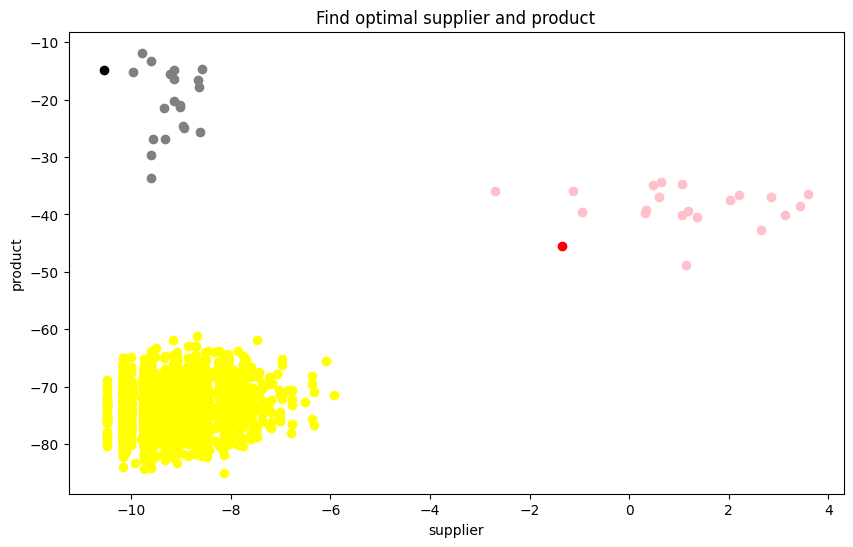

In [97]:
# now plot
figure(figsize=(10, 6), dpi=100)
plt.scatter(dwave_plot_sup1,dwave_plot_prod1,color='black')
plt.scatter(dwave_plot_sup2,dwave_plot_prod2,color='red')

# now plot
plt.scatter(plot_sup1,plot_prod1,color='gray')
plt.scatter(plot_sup2,plot_prod2,color='pink')

plt.scatter(dwave_plot_sup3,dwave_plot_prod3,color='yellow')
plt.scatter(dwave_plot_sup4,dwave_plot_prod4,color='blue')

            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')
plt.show()

In [ ]:
# Next line tries many parameters and will take time to execute
# It will also use up considerable execution time from your monthly D-Wave LEAP subscription

In [98]:
dwave_plot_sup3=[]
dwave_plot_prod3=[]
dwave_plot_sup4=[]
dwave_plot_prod4=[]

save_sup_list=[]
save_sup_energy=[]
save_item_list=[]
save_item_energy=[]


for A in np.arange(0.9, 1.0, 0.2):
    for S in np.arange (2.0, 3.5, 0.5):
        for I in np.arange (0.5, 1.0, 0.2):
            print('Starting:',A,S,I)
            Ma2=Ma.copy()
            Ma2 = np.where(Ma2==1, -A, 0)
            Mz=np.zeros([len(Mi),len(Ms)],dtype=float)
            Msz=np.append(S*Ms, Mz, axis=0)
            Mai=np.append(Ma2, I*Mi, axis=0)
            Mf=np.append(Msz,Mai, axis=1)

            result=run_dwave(Mf,0.5)

            for datum in (result.data()):
                sup_list=[]
                item_list=[]
                for s in range(len(Ms)):
                    if datum.sample[s]==1:
                        sup_list.append(s)


                for i in range(len(Ms),len(Ms)+len(Mi)):
                    if datum.sample[i]==1:
                        item_list.append(i-len(Ms))


                sup_energy=0
                for i in sup_list:
                    for j in sup_list:
                        if i<=j:
                            sup_energy+=Ms[i,j]


                item_energy=0
                for i in item_list:
                    for j in item_list:
                        if i<=j:
                            item_energy+=Mi[i,j]


                a=availability(sup_list,Ma)


                # Is this feasible:
                if(np.isin(False,(np.isin(item_list,a)))):

                    dwave_plot_sup3.append(sup_energy)
                    dwave_plot_prod3.append(item_energy)
                else:
                    print('Feasible')
                    print('suppliers:',sup_energy, sup_list)
                    print('products:', item_energy, item_list)
                    save_sup_energy.append(sup_energy)
                    save_sup_list.append(sup_list)
                    save_item_energy.append(item_energy)
                    save_item_list.append(item_list)
                    
                    dwave_plot_sup4.append(sup_energy)
                    dwave_plot_prod4.append(item_energy)


Starting: 0.9 2.0 0.5
32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
0     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
4     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
5     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       2 ...
8     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
26    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
41    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
47    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
53    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
55    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
67    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -169.10582       1 ...
128   1  1  1  0  0  1  1  1  1  1  1  1 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.19999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.19999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.19999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 1

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -44.71999999999934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.8099999999991 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.8099999999991 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -47.46999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.25999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.25999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -50.63999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.42999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.029999999999156 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -50.70999999999904 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -48.31999999999924 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -48.31999999999924 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15,

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -40.97999999999934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.26999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.26999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1

Feasible
suppliers: -0.13120999999999866 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -45.23999999999932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -47.389999999999304 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 29, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -47.389999999999304 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -49.02999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -54.119999999999216 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -48.689999999999195 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -52.099999999999085 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -40.97999999999934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 29, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -50.25999999999913 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -51.489999999999235 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -51.47999999999905 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -46.06999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -50.879999999999164 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -50.879999999999164 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -45.1599999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -46.20999999999919 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -58.80999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.99999999999915 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22,

Feasible
suppliers: -3.2405899999999996 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29]
products: -49.089999999999094 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.45999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 29, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.64999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25, 26

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -55.55999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -57.92999999999925 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -48.33999999999903 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -57.34999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -58.90999999999922 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -0.13120999999999866 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -53.14999999999916 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27

32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
381   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.18996       1 ...
271   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.18396       1 ...
0     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.16396       1 ...
5     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.16396       1 ...
575   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.16396       1 ...
1499  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.16396       1 ...
114   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.07882       1 ...
2191  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.07882       1 ...
1937  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.07282       1 ...
58    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.05982       1 ...
74    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -179.05

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -63.539999999999196 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -62.029999999999205 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -59.429999999999175 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22,

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -60.509999999999245 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -60.509999999999245 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -60.509999999999245 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -61.41999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -63.749999999999204 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -66.31999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -58.499999999999176 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -58.499999999999176 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -58.499999999999176 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -59.65999999999916 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -65.86999999999924 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -65.85999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -68.02999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.7999999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.7999999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -63.90999999999924 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -65.16999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -0.3793909999999984 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.54999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 25, 26

Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.21999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -0.7474609999999962 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.06999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -67.19999999999925 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -63.299999999999216 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.63999999999932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.63999999999932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 

Feasible
suppliers: -2.2322899999999994 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29]
products: -66.72999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.7099999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -63.9299999999992 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.34999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.90999999999924 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 60, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -62.409999999999236 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 24, 25, 26, 32, 33, 

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -65.64999999999922 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.650159999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -69.25999999999931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.274941000000001 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -67.99999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 3

32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
102   1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...   1 -192.411522       1 ...
394   1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...   1 -192.411522       1 ...
0     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.39696       1 ...
180   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.39696       1 ...
228   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.39696       1 ...
601   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.39696       1 ...
1804  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.39696       1 ...
11    1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...   1 -192.267522       1 ...
62    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -192.25296       1 ...
32    1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...   1 -192.213522       1 ...
227   1  1  1  1  0  1  1  1  1  1  1  1  0  0 ...   1 -192.213

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -72.72999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.71999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -72.71999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65

Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -76.13999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.7447609999999996 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -78.14999999999941 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.46999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 4

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.77999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -0.3793909999999984 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -66.02999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.030079999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.12999999999931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24, 25, 26, 34, 37, 38, 39, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.4799999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.4799999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.4799999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -78.17999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -78.17999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.030079999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.5399999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 

Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -73.81999999999938 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 27, 34, 37, 38, 39, 40, 42, 44, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 61, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.7447609999999996 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.8299999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.82999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 45, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.52999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -74.58999999999934 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.8497610000000004 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.39999999999941 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -69.19999999999938 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.6752610000000008 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -79.35999999999946 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 59, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -73.08999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51, 52, 53

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -73.6299999999995 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.5099999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 24, 25, 26, 34, 36, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -0.1925909999999972 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -75.15999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 

Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -80.03999999999952 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -77.00999999999944 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -68.89999999999935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 24, 25, 26, 27, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.2999999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.030079999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.47999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 25, 26, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -67.09999999999931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 45, 46, 48, 50, 51, 52, 53,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.18999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.0799999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 22, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -71.12999999999941 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 

32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
10    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
75    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
215   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
223   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
418   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
600   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
2763  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0642       1 ...
718   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0612       1 ...
1555  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0612       1 ...
2557  1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0612       1 ...
248   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1   -170.0

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -42.519999999999285 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -46.74999999999913 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.129999999999164 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -51.80999999999913 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -41.55999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.90999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -50.299999999999265 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -50.289999999999225 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -47.219999999999104 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 2

Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -45.07999999999946 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79]
Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -53.449999999999115 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.94999999999932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -62.989999999999256 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -57.82999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -57.80999999999919 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -67.36999999999932 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.76999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.27999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.25999999999931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -59.92999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -66.82999999999937 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.95999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -68.51999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -68.98999999999931 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -66.83999999999938 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -63.43999999999934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.52999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 52,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.05999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 42, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.63999999999919 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.43999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42,

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -62.619999999999266 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -2.68521 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -69.52999999999935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -71.0999999999993 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -59.55999999999927 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -55.22999999999919 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 49, 50, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.49999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 42,

Feasible
suppliers: -3.650159999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -62.56999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 62, 63, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.4699999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -61.529999999999255 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37,

Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -58.649999999999196 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.85999999999935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -67.3799999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -72.57999999999943 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -65.34999999999937 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.139999999999304 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 27, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -66.59999999999937 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 45, 46, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -3.030079999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.70999999999925 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 62, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.83999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 46, 4

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -66.2799999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.27999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.5799999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 47, 48, 50, 52, 5

Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.46999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -65.16999999999925 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -64.51999999999929 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42

Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -66.45999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -66.45999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.9299999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58,

Feasible
suppliers: -2.145179999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.95999999999941 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 62, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.67999999999935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -68.05999999999936 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 5

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.58999999999934 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.030079999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -72.92999999999937 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 53, 55, 56, 57, 58, 59, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -69.57999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 46, 48, 50, 51, 52, 53

Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -66.7199999999993 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -70.06999999999947 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 53, 55, 56, 57, 58, 63, 65, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.650159999999999 [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -74.13999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 46, 48, 50, 53, 55, 56, 57, 58, 59, 6

32451855365842672678315602057625600
chain strength: 0.5 shots: 3000
      0  1  2  3  4  5  6  7  8  9 10 11 12 13 ... 109      energy num_oc. ...
11    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.10135       1 ...
51    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.10135       1 ...
80    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.10135       1 ...
176   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.10135       1 ...
672   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.10135       1 ...
4     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.08135       1 ...
23    1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.08135       1 ...
312   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.08135       1 ...
856   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.08135       1 ...
394   1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.02135       1 ...
0     1  1  1  0  0  1  1  1  1  1  1  1  0  0 ...   1  -172.00

Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.13999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -49.25999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.13999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.26999999999921 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -3.1924799999999993 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -51.13999999999918 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -53.16999999999916 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -52.80999999999914 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.999249999999998 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 25, 26, 27, 28, 29]
products: -47.059999999999135 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 36, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -53.16999999999916 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 27, 32, 34, 35,

Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -47.98999999999913 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 35, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 57, 58, 63, 65, 66, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -1.7654099999999984 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
products: -56.67999999999912 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -55.59999999999917 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -59.459999999999184 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -56.82999999999916 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.59999999999922 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 4

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -63.499999999999254 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -64.27999999999926 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -62.989999999999256 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -60.129999999999214 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -63.94999999999935 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 65, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.57846 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 15, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -62.9199999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -61.55999999999923 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 23, 24, 25, 26, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 49, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.07459 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 22, 23, 24, 26, 27, 28, 29]
products: -67.81999999999933 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -70.06999999999941 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55

Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -68.9099999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -61.58999999999927 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 22, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 51, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -5.34476 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
products: -62.1099999999992 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 22, 23, 24, 25, 26, 27, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 60,

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.43999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.43999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -75.43999999999939 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.75999999999934 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.75999999999934 [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -69.74999999999937 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.9099999999994 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 23, 24, 25, 26, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -73.89999999999947 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 20, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
Feasible
suppliers: -2.7447609999999996 [0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -73.1899999999993 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 34, 37, 38, 39, 40, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 59, 63, 65

Feasible
suppliers: -4.04458 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 25, 26, 27, 28, 29]
products: -74.81999999999942 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 23, 25, 26, 32, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


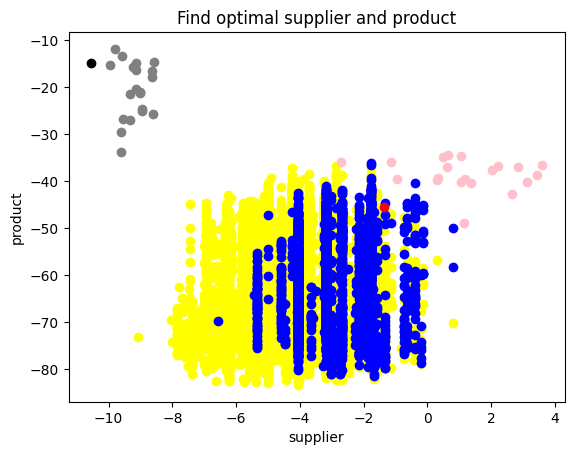

In [99]:
#figure(figsize=(10, 6), dpi=300)
plt.scatter(dwave_plot_sup3,dwave_plot_prod3,color='yellow')
plt.scatter(dwave_plot_sup4,dwave_plot_prod4,color='blue')
# now plot
plt.scatter(plot_sup1,plot_prod1,color='gray')
plt.scatter(plot_sup2,plot_prod2,color='pink')


# now plot
plt.scatter(dwave_plot_sup1,dwave_plot_prod1,color='black')
plt.scatter(dwave_plot_sup2,dwave_plot_prod2,color='red')

            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')
plt.show()

In [100]:
S=10
I=1
global_score=[]
for i in range(len(save_sup_energy)):
    global_score.append(S*save_sup_energy[i]*I*save_item_energy[i])
    
index=np.argsort(global_score)
print(index,global_score[index[-1]])
print('supplier',save_sup_energy[index[-1]])
print(save_sup_list[index[-1]])
print('product',save_item_energy[index[-1]])
print(save_item_list[index[-1]])

[1801  615  854 ... 3291 3230 3582] 4580.823081999957
supplier -6.56843
[0, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
product -69.73999999999934
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]


In [101]:
ef_sup_energy=[]
ef_item_energy=[]
N=20
n=0
for i in reversed(index):
    if n<N:
        print(global_score[i])
        print(' supplier',save_sup_energy[i])
        print('',save_sup_list[i])
        print(' product',save_item_energy[i])
        print('',save_item_list[i])
        ef_sup_energy.append(save_sup_energy[i])
        ef_item_energy.append(save_item_energy[i])
    
    n+=1
    

4580.823081999957
 supplier -6.56843
 [0, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
 product -69.73999999999934
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 45, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 65, 66, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
4028.345611999967
 supplier -5.34476
 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
 product -75.36999999999938
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 52, 53, 55, 56, 57, 58, 63, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]
4016.052663999969
 supplier -5.34476
 [0, 1, 2, 5, 6, 7, 8, 9, 10, 11, 14, 17, 18, 20, 21, 23, 24, 26, 27, 28, 29]
 product -75.13999999999942
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 23, 24, 25, 26, 32, 33, 34, 37, 38, 39, 40, 41, 42, 44, 46, 48, 50, 53, 55, 56, 57, 58, 63

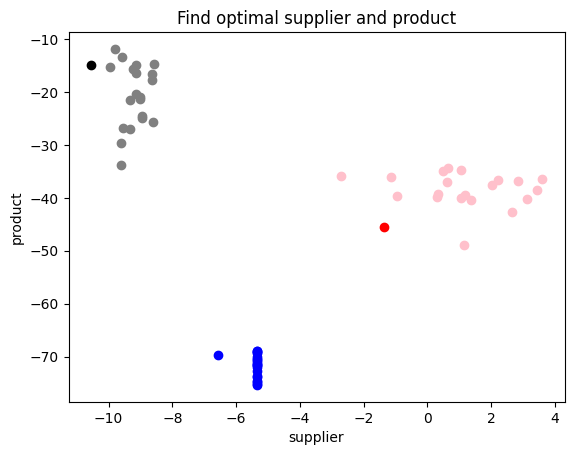

In [102]:
#figure(figsize=(10, 6), dpi=300)
plt.scatter(ef_sup_energy,ef_item_energy,color='blue')

# now plot
plt.scatter(plot_sup1,plot_prod1,color='gray')
plt.scatter(plot_sup2,plot_prod2,color='pink')


# now plot
plt.scatter(dwave_plot_sup1,dwave_plot_prod1,color='black')
plt.scatter(dwave_plot_sup2,dwave_plot_prod2,color='red')

            
plt.xlabel('supplier')
plt.ylabel('product')
plt.title('Find optimal supplier and product')
plt.show()